# Accurate Integer Mathematics in Transformers - Analyse the Model

This CoLab analyses a Transformer model that performs integer addition, subtraction and multiplication e.g. 133357+182243=+0315600, 123450-345670=-0123230 and 000345*000823=+283935. Each digit is a separate token. For 6 digit questions, the model is given 14 "question" (input) tokens, and must then predict the corresponding 8 "answer" (output) tokens.

## Tips for using the Colab
 * You can run and alter the code in this CoLab notebook yourself in Google CoLab ( https://colab.research.google.com/ ).
 * To run the notebook, in Google CoLab, **you will need to** go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.
 * Some graphs are interactive!
 * Use the table of contents pane in the sidebar to navigate.
 * Collapse irrelevant sections with the dropdown arrows.
 * Search the page using the search in the sidebar, not CTRL+F.

# Part 0: Import libraries
Imports standard libraries. Don't bother reading.

In [ ]:
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    !pip install matplotlib
    !pip install prettytable

    !pip install kaleido
    !pip install transformer_lens
    !pip install torchtyping
    !pip install transformers

    !pip install numpy --upgrade
    !pip install scikit-learn --upgrade

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook


In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import kaleido
import plotly.io as pio

if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

import plotly.express as px
import plotly.graph_objects as go

Using renderer: colab


In [ ]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [ ]:
import json
import torch
import torch.nn.functional as F
import numpy as np
import random
from prettytable import PrettyTable
import itertools
import re

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import textwrap

# Use Principal Component Analysis (PCA) library
use_pca = True
try:
  from sklearn.decomposition import PCA
except Exception as e:
  # If this fails try "Runtime > Restart session and run all" as this sometimes fixes the issue.
  print("pca import exception:", e)
  use_pca = False

pca import exception: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'


In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


# Part 1A: Configuration: Detailed

In [ ]:
# Tokens used in vocab. (Token indexes 0 to 9 represent digits 0 to 9)
PLUS_INDEX = 10
MINUS_INDEX = 11
EQUALS_INDEX = 12
MULT_INDEX = 13
DIV_INDEX = 14
MAX_INDEX = DIV_INDEX

In [ ]:
# Main configuration class for main model creation and training
class Config():
  #@markdown Main Model
  n_layers: int = 3 #@param
  n_heads: int = 4 #@param

  d_vocab: int = MAX_INDEX+1
  d_model: int = 510
  d_mlp: int = 4 * d_model
  d_head: int = 170
  training_seed: int = 372001
  analysis_seed: int = 673023

  #@markdown Data
  n_digits: int = 6 #@param
  act_fn: str = 'relu'
  batch_size: int = 512 # Training used 64. Larger for speed during analysis

  def n_ctx(self):
    return 3 * self.n_digits + 4

  #@markdown Optimizer
  n_training_steps: int = 40000 #@param
  weight_decay: float = 0.00008
  lr: int = 0.1

  #@markdown Actions

  # Percent of questions that are multiplication, subtraction (rest are addition questions).
  perc_mult: int = 0 # e.g. 20
  perc_sub: int = 0 #@param e.g. 80
  def perc_add(self):
    return max(0, 100 - self.perc_mult - self.perc_sub)

  #@markdown Insert Model
  insert_mode: int = 0 #@param 0=None 1=Init, 2=FreezeHeads 3=FreezeAll


  # Save graphs to CoLab temp files as PDF, SVG, etc. You can manually export files for re-use in papers.
  save_graph_to_file: bool = True

  # The format to output prettytable in. Options are text|html|json|csv|latex
  # Use Text for this CoLab, latex for Overleaf output, and html for GitHub blog output
  table_out_format: str = "text"


  def first_answer_digit_index(self):
    return self.n_digits*2 + 2


cfg = Config()

# Part 1B: Configuration: Summary

Which existing model do we want to analyse?

The existing model weightings created by the sister Colab [Accurate_Math_Train](https://github.com/PhilipQuirke/transformer-maths/blob/main/assets/Accurate_Math_Train.ipynb) are loaded from HuggingFace.

In [ ]:
# Which existing model do we want to analyse?
#model_name = "add_d5_l2_h3_train15K"  # 5 digit addition model
#model_name = "add_d6_l2_h3_train15K"  # 6 digit addition model
#model_name = "sub_d6_l2_h3_train30K"  # 6 digit subtraction model
#model_name = "mix_d6_l3_h4_train40K"  # 6 digit addition and subtraction model. AvgFinalLoss=8e-09
model_name = "ins1_mix_d6_l3_h4_train40K"  # 6 digit addition / subtraction model. Initialise with addition model. Handles 1m Qs for Add and Sub
#model_name = "ins2_mix_d6_l4_h4_train40K"  # 6 digit addition / subtraction model. Initialised with addition model. Reset useful heads every 100 epochs. AvgFinalLoss=7e-09. Fails 1m Qs
#model_name = "ins3_mix_d6_l4_h3_train40K"  # 6 digit addition / subtraction model. Initialised with addition model. Reset useful heads & MLPs every 100 epochs. AvgFinalLoss=2.6e-06. Fails 1m Qs

In [ ]:
if model_name != "":

  match = re.search("d(\d)_", model_name)
  if match:
    cfg.n_digits = int(match.group(1))

  match = re.search("l(\d)_", model_name)
  if match:
    cfg.n_layers = int(match.group(1))

  match = re.search("h(\d)_", model_name)
  if match:
    cfg.n_heads = int(match.group(1))

  match = re.search("train(\d\d)K", model_name)
  if match:
    cfg.n_training_steps = int(match.group(1)) * 1000

  cfg.perc_sub = 0
  cfg.insert_mode = 0

  if model_name == "mix_d6_l3_h4_train40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 66 # Train on 66% subtraction and 33% addition question batches

  if model_name == "ins1_mix_d6_l3_h4_train40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    cfg.insert_mode = 1 # Initialise with add_d6_l2_h3_train15K.pth.

  if model_name == "ins2_mix_d6_l4_h4_train40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    cfg.insert_mode = 2 # Initialise with add_d6_l2_h3_train15K.pth. Train & reset useful heads every 100 epochs

  if model_name == "ins3_mix_d6_l4_h3_train40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    cfg.insert_mode = 3 # Initialise with add_d6_l2_h3_train15K.pth. Trained & reset useful heads & MLPs every 100 epochs

In [ ]:
def file_name_suffix(digits, layers, heads, training_steps, seed):
  train_str = str(training_steps//1000) + "K"
  return '_d{}_l{}_h{}_train{}_seed{}'.format(digits, layers, heads, train_str, seed)

op_prefix = 'mul' if cfg.perc_mult == 100 else 'sub' if cfg.perc_sub == 100 else 'add' if cfg.perc_add() == 100 else 'mix'
main_fname = '' if cfg.insert_mode == 0 else 'ins{}_'.format(cfg.insert_mode)
main_fname += op_prefix
main_fname += file_name_suffix(cfg.n_digits, cfg.n_layers, cfg.n_heads, cfg.n_training_steps, cfg.training_seed)
main_fname_pth = main_fname + '.pth'
main_fname_json = main_fname + '_analysis.json'


def print_config():
  print("%Mult=", cfg.perc_mult, "%Sub=", cfg.perc_sub, "%Add=", cfg.perc_add(), "File=", main_fname)

print_config()
print('Main model will be read from HuggingLab file', main_fname_pth)
print('Main model quanta tags will save to Colab temporary file', main_fname_json)

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001
Main model will be read from HuggingLab file ins1_mix_d6_l3_h4_train40K_seed372001.pth
Main model quanta tags will save to Colab temporary file ins1_mix_d6_l3_h4_train40K_seed372001_tags.json


# Part 3A: Set Up: Embedding / Unembedding

Convert from
- Human-readable character to numeric token index.
- Convert numeric token positions to position "meanings"
- Convert from number to human-readable stringand vice versa

In [ ]:
# Map from character to token
char_to_token = {str(i) : i for i in range(10)}
char_to_token['+']=PLUS_INDEX
char_to_token['-']=MINUS_INDEX
char_to_token['=']=EQUALS_INDEX
char_to_token['*']=MULT_INDEX
char_to_token['\\']=DIV_INDEX

In [ ]:
# Map from token to character
def token_to_char(i):
  for char, token in char_to_token.items():
    if token == i:
      return char

  return '?' # Should never happen


assert token_to_char(4) == '4'
assert token_to_char(MULT_INDEX) == '*'


# Map from tokens to string
def tokens_to_string(tokens):
    tokens = utils.to_numpy(tokens)
    return "".join([token_to_char(i) for i in tokens[:cfg.n_ctx()]])


assert tokens_to_string([4,0,7]) == '407'

In [ ]:
# convert 3 to "P3"
def position_name(position):
  return "P" + str(position)


# Token positions names P1 .... P20
token_position_names = []
for i in range(cfg.n_ctx()):
  token_position_names += [position_name(i)]


# Convert D0 to P5, D1 to P4, D2 to P3 in 6 digit addition
def dn_to_position_name(n):
  return position_name(cfg.n_digits - 1 - n)
# Convert D'0 to P10, D'1 to P9, D'2 to P8, etc in 6 digit addition
def ddn_to_position_name(n):
  return position_name(2 * cfg.n_digits - n)
# Convert A0 to P20, A1 to P19, A2 to P18, etc in 6 digit addition
def an_to_position_name(n):
  return position_name(cfg.n_ctx() - 1 - n)


# convert 3 to "A3"
def answer_name(n):
  return "A" + str(n)


# Token position meanings D5, .., D0, *, D5', .., D0', =, A7, A6, .., A0
token_position_meanings = []

for i in range(cfg.n_digits):
  token_position_meanings += ["D" + str(cfg.n_digits-i-1)]

token_position_meanings += "+" # Stands in for operation +, - or *

for i in range(cfg.n_digits):
  token_position_meanings += ["D'" + str(cfg.n_digits-i-1)]

token_position_meanings += ["="]

for i in range(cfg.n_digits+2):
  token_position_meanings += [answer_name(cfg.n_digits-i+1)]

In [ ]:
def int_to_answer_str( n ):
  s = str(abs(n))
  while len(s) < cfg.n_digits + 1 :
    s = "0" + s
  s = ("+" if n >= 0 else "-") + s
  return s


# Unit test
if cfg.n_digits == 6 :
  assert int_to_answer_str(1234) == "+0001234"

In [ ]:
# Convert "0012345" to 12345
def tokens_to_unsigned_int( q, offset, digits ):
  a = 0
  for j in range(digits):
    a = a * 10 + q[offset+j]
  return a


# Convert "-12345" to -12345, and "+12345" to 12345
def tokens_to_answer(q):
  # offset of sign character
  sign_offset = cfg.first_answer_digit_index()

  # 5 digit addition yields a 6 digit answer. So cfg.n_digits+1 DIGITS
  answer_digits = cfg.n_digits+1

  a = tokens_to_unsigned_int( q, sign_offset+1, answer_digits )
  if q[sign_offset] == MINUS_INDEX:
    a = - a

  return a

# Part 3B: Set Up: Create model

In [ ]:
# Transformer creation

# Structure is documented at https://neelnanda-io.github.io/TransformerLens/transformer_lens.html#transformer_lens.HookedTransformerConfig.HookedTransformerConfig
ht_cfg = HookedTransformerConfig(
    n_layers = cfg.n_layers,
    n_heads = cfg.n_heads,
    d_model = cfg.d_model,
    d_head = cfg.d_head,
    d_mlp = cfg.d_mlp,
    act_fn = cfg.act_fn,
    normalization_type = 'LN',
    d_vocab = cfg.d_vocab,
    d_vocab_out = cfg.d_vocab,
    n_ctx = cfg.n_ctx(),
    init_weights = True,
    device = "cuda",
    seed = cfg.training_seed,
)

main_model = HookedTransformer(ht_cfg)

optimizer = torch.optim.AdamW(main_model.parameters(),
                        lr = cfg.lr,
                        weight_decay = cfg.weight_decay,
                        betas = (0.9, 0.98))

max_iter = cfg.n_training_steps
warmup_iter = max_iter // 5
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=int(warmup_iter))
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(np.ceil((max_iter-warmup_iter))))
scheduler  = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[int(warmup_iter)])

# Part 4: Set Up: Loss Function & Data Generator
This section defines the loss function and the training/tesing data generator.

In [ ]:
# Loss functions

# Calculate the per-token probability by comparing a batch of prediction "logits" to answer "tokens"
def logits_to_tokens_loss(logits, tokens):
  # Addition answer can have one extra digit than question. Answer also has a +/- sign
  n_answer_digits = cfg.n_digits+2

  # The addition answer digit token probabilities
  ans_logits = logits[:, -(n_answer_digits+1):-1]

  # Convert raw score (logits) vector into a probability distribution.
  # Emphasize the largest scores and suppress the smaller ones, to make them more distinguishable.
  ans_probs = F.log_softmax(ans_logits.to(torch.float64), dim=-1)

  max_prob_tokens = torch.argmax(ans_probs, dim=-1)

  # The addition answer digit tokens
  ans_tokens = tokens[:, -(n_answer_digits):]

  # Extract values from the ans_probs tensor, based on indices from the ans_tokens tensor
  ans_loss = torch.gather(ans_probs, -1, ans_tokens[:, :, None])[..., 0]

  return ans_loss, max_prob_tokens


# Calculate loss as negative of average per-token mean probability
def loss_fn(ans_loss):
  return -ans_loss.mean(0)

In [ ]:
# Generate an enriched data batch for one operator type
# "Addition" batch entries are formated XXXXX+YYYYY=+ZZZZZZ e.g. 550030+800020=+1350050
# "Subtraction" batch entries are formated XXXXX-YYYYY=-ZZZZZZ e.g. 550030-800020=-0249990, 800020-550030=+0249990
# "Multiplication" batch entries are formated 000XXX*000YYY=+ZZZZZZ e.g. 000345*000678=+233910
def data_generator_core( batch_op ):

  batch = torch.zeros((cfg.batch_size, cfg.n_ctx())).to(torch.int64)
  x = torch.randint(0, 10, (cfg.batch_size, cfg.n_digits))
  y = torch.randint(0, 10, (cfg.batch_size, cfg.n_digits))

  if batch_op == MULT_INDEX:
    # Convert from NNNNNN*NNNNNN= to 000NNN*000NNN= so answer (product) is NNNNNN
    num_zeros = cfg.n_digits // 2
    for z in range(num_zeros):
      x[:, z] = 0
      y[:, z] = 0

  # Enrich the question data on 60% of batches to speed up training
  if ( batch_op == PLUS_INDEX or batch_op == MINUS_INDEX ) and (random.randint(1, 5) < 3):
    # Flatten x and y to 1D tensors
    x_flat = x.view(-1)
    y_flat = y.view(-1)

    if batch_op == PLUS_INDEX :
      # The UseSum9 task is compound and rare and so hard to learn.
      # Increase the MakeSum9 case frequency
      # UseSum9 also relies on MakeCarry1 (50%) from previous column.
      num_elements_to_modify = int(0.40 * x.numel()) # 40%
      indices_to_modify = torch.randperm(x_flat.numel())[:num_elements_to_modify]
      if random.randint(1, 2) == 1:
        x_flat[indices_to_modify] = 9 - y_flat[indices_to_modify]
      else:
        y_flat[indices_to_modify] = 9 - x_flat[indices_to_modify]
    else:
      # Empirically, the model seems to struggle with the sign calculation.
      # Minus signs are rarer than positive signs.
      # Generate more negative answers by increasing the y value
      y_flat[y_flat < 9] += 1

    # Reshape x and y back to its original shape
    x = x_flat.view(x.shape)
    y = y_flat.view(x.shape)


  first_answer_index = cfg.first_answer_digit_index()

  batch[:, :cfg.n_digits] = x
  batch[:, cfg.n_digits] = batch_op
  batch[:, 1+cfg.n_digits:1+cfg.n_digits*2] = y
  batch[:, first_answer_index-1] = EQUALS_INDEX

  # Convert each row into a 5-digit number
  x_values = x[:, 0]
  y_values = y[:, 0]
  for dn in range(1,cfg.n_digits):
    x_values = x_values * 10 + x[:, dn]
    y_values = y_values * 10 + y[:, dn]

  # Elementwise operations to give the 1D tensor answers
  if batch_op == MULT_INDEX:
    answers = x_values * y_values
  else:
    if batch_op == MINUS_INDEX:
      answers = x_values - y_values
    else:
      answers = x_values + y_values

  # Insert the answers into the batch
  for i in range(cfg.batch_size):
    answer = answers[i]

    sign = PLUS_INDEX
    if answer < 0:
      sign = MINUS_INDEX
      answer = - answer

    batch[i, first_answer_index] = sign
    for j in range(cfg.n_digits+1):
      batch[i, cfg.n_ctx()-j-1] = answer % 10
      answer = answer // 10
      if answer == 0:
          break

  return batch

In [ ]:
# Define "iterator" data generator function. Invoked using next().
def data_generator( ):
  torch.manual_seed(cfg.analysis_seed)
  while True:

    batch_rand = random.randint(1, 100)
    batch_op = MULT_INDEX if batch_rand <= cfg.perc_mult else MINUS_INDEX if batch_rand <= cfg.perc_mult + cfg.perc_sub else PLUS_INDEX

    batch = data_generator_core( batch_op )

    yield batch.cuda()

In [ ]:
# Initialise the data generator
ds = data_generator()

In [ ]:
# Test data generator
tokens = next(ds)
print(tokens[:3,:])

tensor([[ 4,  9,  7,  0,  1,  8, 11,  1,  0,  7,  2,  3,  4, 12, 10,  0,  3,  8,
          9,  7,  8,  4],
        [ 9,  2,  8,  9,  9,  4, 11,  5,  4,  1,  1,  9,  8, 12, 10,  0,  3,  8,
          7,  7,  9,  6],
        [ 5,  8,  9,  8,  9,  3, 11,  4,  5,  4,  2,  9,  3, 12, 10,  0,  1,  3,
          5,  6,  0,  0]], device='cuda:0')


# Part 5: Set Up: Load Model from HuggingFace

In [ ]:
main_repo_name="PhilipQuirke/Accurate6DigitSubtraction"
print("Loading model from HuggingFace", main_repo_name, main_fname_pth)

main_model.load_state_dict(utils.download_file_from_hf(repo_name=main_repo_name, file_name=main_fname_pth, force_is_torch=True))
main_model.eval()

Loading model from HuggingFace PhilipQuirke/Accurate6DigitSubtraction ins1_mix_d6_l3_h4_train40K_seed372001.pth


(…)ns1_mix_d6_l3_h4_train40K_seed372001.pth:   0%|          | 0.00/41.8M [00:00<?, ?B/s]

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

# Part 6A: Set Up: Quanta types supported

For each node we evaluate a range of quanta

In [ ]:
# Token position tag
POSITION_MAJOR_TAG = "Position"


# What % of questions failed when we ablated a specific node. A low percentage indicates a less common use case
FAIL_MAJOR_TAG = "FailPerc"


# What input tokens digits (e.g. "D'3") are attended to by a specific node.
ATTENTION_MAJOR_TAG = "Attn"


# What answer digits (e.g. "A543") were impacted when we ablated a specific node.
IMPACT_MAJOR_TAG = "Impact"

NO_IMPACT_TAG = "(none)"


# What mathematical operation was in the question being ablated?
ADDITION_MAJOR_TAG = "Complexity.Add"
SUBTRACTION_MAJOR_TAG = "Complexity.Sub"
VARIED_MAJOR_TAG = "Complexity.Varied" # Uknown
# Addition operation "complexity" minor tags
COMPLEXITY_S0_TAG = "S0"
COMPLEXITY_S1_TAG = "S1"
COMPLEXITY_S2_TAG = "S2"
COMPLEXITY_S3_TAG = "S3"
COMPLEXITY_S4_TAG = "S4"
COMPLEXITY_S5_TAG = "S5"
# Subtraction operation "complexity" minor tags
COMPLEXITY_M0_TAG = "M0"
COMPLEXITY_M1_TAG = "M1"
COMPLEXITY_M2_TAG = "M2"
COMPLEXITY_M3_TAG = "M3"
COMPLEXITY_NG_TAG = "NG"


# What algorithmic purpose is this node serving?
ALGORITHM_MAJOR_TAG = "Algorithm"
ALGORITHM_BA_TAG = "BA" # Base Add (Dn, D'n)
ALGORITHM_MC_TAG = "MC" # MakeCarry (Dn, D'n)
ALGORITHM_C_TAG = "C" # TriCase (Dn, D'n)

# Part 6B: Set up: Evaluate answer-digit Impact quanta e.g. "A654"

In [ ]:
# Compare each digit in the answer. Returns a A645 pattern where '4' means a failed 4th digit. A "-" sign failure is shown as "A7"
def get_answer_impact_meaning_str(answer1_str, answer2_str):

  impact = ""
  sign_offset = cfg.first_answer_digit_index()
  for i in range(cfg.n_digits+2):
    impact += "" if answer2_str[i] == answer1_str[i] else token_position_meanings[sign_offset + i]

  if impact == "":
    return ""

  impact = impact.replace("A", "")
  char_list = list(impact)
  char_list = sorted(char_list, reverse=True)
  impact = ''.join(char_list)

  assert not 'D' in impact

  return "A" + impact


# Compare each digit in the answer. Returns a A645 pattern where '4' means a failed 4th digit. Can fail on the "-" sign.
def get_answer_impact_meaning(question_and_answer, answer_str2):

  answer1_str = tokens_to_string(question_and_answer[-(cfg.n_digits+2):])

  return get_answer_impact_meaning_str(answer1_str, answer_str2)

# Part 6C: Set Up: Create sample questions by Complexity Quanta

Sets of sample questions by complexity quanta

In [ ]:
# Insert a number into the question
def insert_question_number(the_question, index, first_digit_index, the_digits, n):

  last_digit_index = first_digit_index + the_digits - 1

  for j in range(the_digits):
    the_question[index, last_digit_index-j] = n % 10
    n = n // 10


# Create a single question
def make_a_question(the_question, index, q1, q2, operator ):

  insert_question_number(the_question, index, 0, cfg.n_digits, q1)

  the_question[index, cfg.n_digits] = operator

  insert_question_number( the_question, index, cfg.n_digits+1, cfg.n_digits, q2)

  the_question[index, 2*cfg.n_digits+1] = EQUALS_INDEX

  answer = q1+q2
  if operator == MINUS_INDEX:
    answer = q1-q2
  else:
    if operator == MULT_INDEX:
      answer = q1*q2

  the_question[index, 2*cfg.n_digits+2] = PLUS_INDEX if answer >= 0 else MINUS_INDEX
  if answer < 0:
    answer = -answer

  insert_question_number(the_question, index, 2*cfg.n_digits + 3, cfg.n_digits+1, answer)


# Create a batch of questions from a 2D matrix of ints
def make_questions(operator, q_matrix):
  max_len = len(q_matrix)
  real_len = 0
  questions = torch.zeros((max_len, cfg.n_ctx())).to(torch.int64)
  limit = 10 ** cfg.n_digits

  for i in range(max_len):
    a = q_matrix[i][0]
    b = q_matrix[i][1]

    if a < limit and b < limit:
      make_a_question(questions, real_len, a, b, operator)
      real_len += 1

  return questions[:real_len]

In [ ]:
# Manually create some questions that strongly test one quanta


# Make BaseAdd questions
def make_s0_questions():
    return ADDITION_MAJOR_TAG, COMPLEXITY_S0_TAG, make_questions( PLUS_INDEX,
      [[0, 0],
      [1, 3],
      [12345, 33333],
      [33333, 12345],
      [45762, 33113],
      [888, 11111],
      [2362, 23123],
      [15, 81],
      [1000, 4441],
      [4440, 11111],
      [24033, 25133],
      [23533, 21133],
      [32500, 1],
      [31500, 1111],
      [5500, 12323],
      [4500, 2209],
      [33345, 66643], # =099988
      [66643, 33345], # =099988
      [10770, 44111],
      [60000, 31111],
      [10000, 21111],
      [107700, 441111],
      [600000, 311111],
      [100000, 211111],
      [1077000, 4411111],
      [6000000, 3111111],
      [1000000, 2111111],
      [10770000, 44111111],
      [60000000, 3111111],
      [10000000, 2111111]])

# Make UseCarry1 (addition) questions
def make_s1_questions():
    return ADDITION_MAJOR_TAG, COMPLEXITY_S1_TAG, make_questions( PLUS_INDEX,
      [[ 15, 45],
      [ 27, 55],
      [ 35, 59],
      [ 150, 451],
      [ 270, 551],
      [ 350, 591],
      [ 1500, 4511],
      [ 2700, 5511],
      [ 3500, 5911],
      [ 40035, 41149],
      # [ 44000, 46000], D6 L1 H3 model cant handle this.
      [ 70000, 41111],
      [ 15000, 25111],
      [ 35000, 35111],
      [ 45000, 35111],
      [ 67000, 25111],
      [ 19000, 76111],
      [ 15020, 45091],
      [ 25002, 55019],
      [ 35002, 59019],
      [ 150211, 450911],
      [ 250021, 550191],
      [ 350021, 590191],
      [ 1502111, 4509111],
      [ 2500211, 5501911],
      [ 3500211, 5901911],
      [ 15021111, 45091111],
      [ 25002111, 55019111],
      [ 35002111, 59019111]])


# Make SimpleUseSum9 (addition) questions
def make_s2_questions():
    return ADDITION_MAJOR_TAG,COMPLEXITY_S2_TAG, make_questions( PLUS_INDEX,
      [[ 55, 45],
      [ 45, 55],
      [ 45, 59],
      [ 35, 69],
      [ 25, 79],
      [ 15, 85],
      [ 15, 88],
      [ 15518, 14511],
      [ 14518, 15511],
      [ 24533, 25933],
      [ 23533, 26933],
      [ 32511, 7911],
      [ 31511, 8511],
      [ 551, 451],
      [ 451, 551],
      [ 10881, 41127],
      [ 41127, 10881],
      [ 12386, 82623],
      [ 108811, 411271],
      [ 411271, 108811],
      [ 123861, 826231],
      [ 994890, 80105],
      [ 970590, 96026],
      [ 994890, 80105],
      [ 970590, 96026],
      [ 1088111, 4112711],
      [ 4112711, 1088111],
      [ 1238611, 8262311],
      [ 10881111, 41127111],
      [ 41127111, 10881111],
      [ 12386111, 82623111]])

# These are two level UseSum9 cascades
def make_s3_questions():
    return ADDITION_MAJOR_TAG, COMPLEXITY_S3_TAG, make_questions( PLUS_INDEX,
      [[ 555, 445],
      [ 3340, 6661],
      [ 8880, 1121],
      [ 1120, 8881],
      [ 123, 877],
      [ 877, 123],
      [ 321, 679],
      [ 679, 321],
      [ 1283, 78785]])


# These are three level UseSum9 cascades
def make_s4_questions():
    return ADDITION_MAJOR_TAG, COMPLEXITY_S4_TAG, make_questions( PLUS_INDEX,
      [[ 5555, 4445],
      [ 55550, 44451],
      [ 3334, 6666],
      [ 33340, 66661],
      [ 8888, 1112],
      [ 88880, 11121],
      [ 1234, 8766],
      [ 4321, 5679]])


# These are four level UseSum9 cascades
def make_s5_questions():
    return ADDITION_MAJOR_TAG, COMPLEXITY_S5_TAG, make_questions( PLUS_INDEX,
      [[ 44445, 55555],
      [ 33334, 66666],
      [ 88888, 11112],
      [ 12345, 87655],
      [ 54321, 45679],
      [ 45545, 54455],
      [ 36634, 63366],
      [ 81818, 18182],
      [ 87345, 12655],
      [ 55379, 44621]])


# Make questions focus mainly on 1 digit at a time
# (assuming that the 0 + 0 digit additions/subtractions are trivial bigrams)
def make_sn_questions():
    return ADDITION_MAJOR_TAG, "S*", make_questions( PLUS_INDEX,
      [[ 1, 0],
      [ 4, 3],
      [ 5, 5],
      [ 8, 1],
      [ 40, 31],
      [ 44, 46],
      [ 400, 311],
      [ 440, 461],
      [ 800, 111],
      [ 270, 471],
      [ 600, 311],
      [ 4000, 3111],
      [ 4400, 4611],
      [ 6000, 3111],
      [ 7000, 4111],
      [ 40000, 31111],
      [ 44000, 45111],
      [ 60000, 31111],
      [ 70000, 41111],
      [ 10000, 21111],
      [ 15000, 25111],
      [ 35000, 35111],
      [ 45000, 85111],
      [ 67000, 85111],
      [ 99000, 76111],
      [ 76000, 99111],
      [ 670000, 851111],
      [ 990000, 761111],
      [ 760000, 991111],
      [ 6700000, 8511111],
      [ 9900000, 7611111],
      [ 7600000, 9911111],
      [ 67000000, 85111111],
      [ 99000000, 76111111],
      [ 76000000, 99111111]])


# Make M0 questions - when no column generates a Borrow One. Answer is always positive (or zero).
def make_m0_questions():
    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M0_TAG, make_questions( MINUS_INDEX,
      [[0, 0],
      [6, 6],
      [61, 60],
      [611, 600],
      [6111, 6000],
      [61111, 60000],
      [611111, 600000],
      [6111111, 6000000],
      [61111111, 60000000],
      [66666, 12345],
      [33333, 12321],
      [45762, 34551],
      [78901, 78901], # = +000000
      [23123, 23123], # = +000000
      [86, 15],
      [4440, 1230],
      [88746, 86544],
      [27833, 25133],
      [23533, 21133],
      [32501, 1],
      [31511, 1111],
      [55555, 12323],
      [45454, 22022],
      [66643, 3341],
      [66643, 30042],
      [99999, 44012],
      [61111, 30000],
      [99111, 99111], # = +000000
      [999991, 440120],
      [611111, 300000],
      [991111, 991111], # = +0000000
      [9999911, 4401200],
      [6111111, 3000000],
      [9911111, 9911111], # = +00000000
      [99999111, 44012000],
      [61111111, 30000000],
      [99111111, 99111111]]) # = +000000000

# Make subtraction M1 questions with exactly one "borrow 1" instance. Answer is always positive.
def make_m1_questions():
    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M1_TAG, make_questions( MINUS_INDEX,
      [[22222, 11113],
      [ 22222, 11131],
      [ 22222, 11311],
      [ 22222, 13111],
      [    14,     8],
      [   141,    80],
      [  1411,   800],
      [ 14111,  8000],
      [ 55514, 11108],
      [ 55141, 11080],
      [ 51411, 10800],
      [ 140111,  8000],
      [ 88888, 22229],
      [ 77777, 22292],
      [ 66666, 22922],
      [ 888888, 222292],
      [ 777777, 222922],
      [ 666666, 229222],
      [ 8888888, 2222922],
      [ 7777777, 2229222],
      [ 6666666, 2292222],
      [ 88888888, 22229222],
      [ 77777777, 22292222],
      [ 66666666, 22922222]])

# Make subtraction M2 questions containing B1 and DZ. Answer is always positive (or zero).
def make_m2_questions():
    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M2_TAG, make_questions( MINUS_INDEX,
      [[22212, 11113],
      [ 22122, 11131],
      [ 21222, 11311],
      [   904,     8],
      [  9041,    80],
      [ 90411,   800],
      [ 55514, 11118],
      [ 55141, 11180],
      [ 51411, 11800],
      [ 88888, 22289],
      [ 77777, 22792],
      [ 66666, 26922],
      [ 888888, 222892],
      [ 777777, 227922],
      [ 666666, 269222],
      [ 8888888, 2228922],
      [ 7777777, 2279222],
      [ 6666666, 2692222],
      [ 88888888, 22289222],
      [ 77777777, 22792222],
      [ 66666666, 26922222]])


# Make subtraction M3,M4,... questions containing B1 and multiple DZs. Answer is always positive (or zero).
def make_m3_questions():
    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M3_TAG, make_questions( MINUS_INDEX,
      [[22112, 11113],
      [ 21122, 11131],
      [ 99004,     8],
      [ 90041,    80],
      [ 55114, 11118],
      [ 51140, 11180],
      [ 88888, 22889],
      [ 87777, 27792],
      [ 888888, 228892],
      [ 877777, 277922],
      [ 8888888, 2288922],
      [ 7777777, 2779222],
      [ 88888888, 22889222],
      [ 77777777, 28892222]])


# Make subtraction questions with negative answers
def make_ng_questions():
    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_NG_TAG, make_questions( MINUS_INDEX,
      [[0, 1],
      [7, 9],
      [12345, 33333],
      [888, 11111],
      [2362, 23123],
      [15, 81],
      [1111, 4440],
      [24033, 25133],
      [23533, 88133],
      [5511, 12323],
      [4511, 22209],
      [ 88888, 88889],
      [ 55555, 55556],
      [ 88881, 88891],
      [ 55551, 55561],
      [ 88811, 88911],
      [ 55511, 55611],
      [ 88746, 89544],
      [ 27833, 29133],
      [ 23533, 23833],
      [ 31511, 41111],
      [ 55555, 62323],
      [ 45454, 72022],
      [ 66643, 73341],
      [ 66643, 90042],
      [ 99998, 99999],
      [ 8, 12],
      [ 41, 232],
      [ 44, 523],
      [ 234, 334],
      [ 7777, 8434],
      [ 88888, 92222],
      [ 77777, 84340],
      [ 888888, 922220],
      [ 777777, 843400],
      [ 8888888, 9222200],
      [ 7777777, 8434000],
      [ 88888888, 92222000],
      [ 77777777, 84340000]])


def make_addition_questions():
  _, _, s0 = make_s0_questions()
  _, _, s1 = make_s1_questions()
  _, _, s2 = make_s2_questions()
  _, _, s3 = make_s3_questions()
  _, _, s4 = make_s4_questions()
  _, _, s5 = make_s5_questions()
  _, _, s6 = make_sn_questions()

  return ADDITION_MAJOR_TAG, "S*", torch.vstack((s0.cuda(), s1.cuda(), s2.cuda(), s3.cuda(), s4.cuda(), s5.cuda(), s6.cuda()))


def make_subtraction_questions():
  _, _, m0 = make_m0_questions()
  _, _, m1 = make_m1_questions()
  _, _, m2 = make_m2_questions()
  _, _, m3 = make_m3_questions()
  _, _, m4 = make_ng_questions()

  return SUBTRACTION_MAJOR_TAG, "M*", torch.vstack((m0.cuda(), m1.cuda(), m2.cuda(), m3.cuda(), m4.cuda()))


v0 = next(ds) # Could be Add, Sub or Mult
v1 = next(ds) # Could be Add, Sub or Mult
if cfg.perc_add() > 0 and cfg.perc_sub > 0 :
  v0 = data_generator_core( PLUS_INDEX )
  v1 = data_generator_core( MINUS_INDEX )


# Returns ~1000 random and up to ~150 manually-chosen questions
def make_varied_questions():
  if cfg.perc_mult == 100 :
    return VARIED_MAJOR_TAG, "All", torch.vstack((v0.cuda(), v1.cuda()))

  _, _, s0 = make_s0_questions()
  _, _, s1 = make_s1_questions()
  _, _, s2 = make_s2_questions()
  _, _, s3 = make_s3_questions()
  _, _, s4 = make_s4_questions()
  _, _, s5 = make_s5_questions()
  _, _, s6 = make_sn_questions()

  _, _, m0 = make_m0_questions()
  _, _, m1 = make_m1_questions()
  _, _, m2 = make_m2_questions()
  _, _, m3 = make_m3_questions()
  _, _, m4 = make_ng_questions()

  if cfg.perc_add() == 100 :
    return ADDITION_MAJOR_TAG, "S*", torch.vstack((v0.cuda(), s0.cuda(), s1.cuda(), s2.cuda(), s3.cuda(), s4.cuda(), v1.cuda()))

  if cfg.perc_sub == 100 :
    return SUBTRACTION_MAJOR_TAG, "M*", torch.vstack((v0.cuda(), m0.cuda(), m1.cuda(), m2.cuda(), m3.cuda(), m4.cuda(), v1.cuda()))

  return VARIED_MAJOR_TAG, "All", torch.vstack((v0.cuda(), s0.cuda(), m0.cuda(), s1.cuda(), m1.cuda(), s2.cuda(), m2.cuda(), s3.cuda(), m3.cuda(), s4.cuda(), m4.cuda(), s5.cuda(), s6.cuda(), v1.cuda()))

# Part 6D: Set Up: Evaluate mathematical Complexity quanta e.g. Add.S2, Sub.M1

Functions to evaluate the question "mathematical complexity" of questions

In [ ]:
# Analyse and return the complexity quanta for the Addition (S0 to S4+) or Subtraction (M0 to NG) questions
def get_question_complexity(question):
  qlist = utils.to_numpy(question)
  inputs = qlist[:2*cfg.n_digits+2]
  operator = qlist[cfg.n_digits]

  if operator == PLUS_INDEX:

    # Locate the MC and MS digits (if any)
    mc = torch.zeros(cfg.n_digits).to(torch.int64)
    ms = torch.zeros(cfg.n_digits).to(torch.int64)
    for dn in range(cfg.n_digits):
      if inputs[dn] + inputs[dn + cfg.n_digits + 1] == 9:
        ms[cfg.n_digits-1-dn] = 1
      if inputs[dn] + inputs[dn + cfg.n_digits +1] > 9:
        mc[cfg.n_digits-1-dn] = 1

    if torch.sum(mc) == 0:
      return ADDITION_MAJOR_TAG, COMPLEXITY_S0_TAG

    if torch.sum(ms) == 0:
      return ADDITION_MAJOR_TAG, COMPLEXITY_S1_TAG

    for dn in range(cfg.n_digits-4):
      if mc[dn] == 1 and ms[dn+1] == 1 and ms[dn+2] == 1 and ms[dn+3] == 1 and ms[dn+4] == 1:
        return ADDITION_MAJOR_TAG, COMPLEXITY_S5_TAG # MC cascades 4 or more digits

    for dn in range(cfg.n_digits-3):
      if mc[dn] == 1 and ms[dn+1] == 1 and ms[dn+2] == 1 and ms[dn+3] == 1:
        return ADDITION_MAJOR_TAG, COMPLEXITY_S4_TAG # MC cascades 3 or more digits

    for dn in range(cfg.n_digits-2):
      if mc[dn] == 1 and ms[dn+1] == 1 and ms[dn+2] == 1:
        return ADDITION_MAJOR_TAG, COMPLEXITY_S3_TAG # MC cascades 2 or more digits

    for dn in range(cfg.n_digits-1):
      if mc[dn] == 1 and ms[dn+1] == 1:
        return ADDITION_MAJOR_TAG, COMPLEXITY_S2_TAG # Simple US 9

    return ADDITION_MAJOR_TAG, COMPLEXITY_S1_TAG


  if operator == MINUS_INDEX:
    a = tokens_to_unsigned_int( question, 0, cfg.n_digits )
    b = tokens_to_unsigned_int( question, cfg.n_digits + 1, cfg.n_digits )
    if a - b < 0:
      return SUBTRACTION_MAJOR_TAG, COMPLEXITY_NG_TAG

    # Locate the B1 and MZ digits (if any)
    b1 = torch.zeros(cfg.n_digits).to(torch.int64)
    mz = torch.zeros(cfg.n_digits).to(torch.int64)
    for dn in range(cfg.n_digits):
      if inputs[dn] - inputs[dn + cfg.n_digits + 1] < 0:
        b1[cfg.n_digits-1-dn] = 1
      if inputs[dn] - inputs[dn + cfg.n_digits +1] == 0:
        mz[cfg.n_digits-1-dn] = 1

    # Evaluate BaseSub questions - when no column generates a Borrow One
    if torch.sum(b1) == 0:
      return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M0_TAG

    # Evaluate subtraction "cascade multiple steps" questions
    for dn in range(cfg.n_digits-3):
      if b1[dn] == 1 and mz[dn+1] == 1 and mz[dn+2] == 1 and mz[dn+3] == 1:
        return SUBTRACTION_MAJOR_TAG, "M4+" # B1 cascades 3 or more digits

    # Evaluate subtraction "cascade multiple steps" questions
    for dn in range(cfg.n_digits-2):
      if b1[dn] == 1 and mz[dn+1] == 1 and mz[dn+2] == 1:
        return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M3_TAG # B1 cascades 2 or more digits

    # Evaluate subtraction "cascade 1" questions
    for dn in range(cfg.n_digits-1):
      if b1[dn] == 1 and mz[dn+1] == 1:
        return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M2_TAG # B1 cascades 1 digit

    return SUBTRACTION_MAJOR_TAG, COMPLEXITY_M1_TAG


  # Should never get here
  print("get_question_complexity OP? exception", question)
  return VARIED_MAJOR_TAG, "OP?"

In [ ]:
def unit_test_quanta_core(make_questions):
  correct_major_tag, correct_complexity, questions = make_questions()
  num_questions = questions.shape[0]
  print( correct_major_tag + ":" + correct_complexity, "#Questions=", num_questions)

  for i in range(num_questions):
    major_tag, complexity = get_question_complexity(questions[i])
    if major_tag != correct_major_tag or complexity != correct_complexity:
      print( "Complexity mismatch:", correct_major_tag, major_tag, correct_complexity, complexity, questions[i])


# Test that our "sample questions by quanta" and "question quanta evaluation" are aligned.
# If this fails, either the sample questions or the evaluation is buggy.
def unit_test_quanta():
  unit_test_quanta_core(make_s0_questions)
  unit_test_quanta_core(make_s1_questions)
  unit_test_quanta_core(make_s2_questions)
  unit_test_quanta_core(make_s3_questions)
  unit_test_quanta_core(make_s4_questions)
  unit_test_quanta_core(make_s5_questions)

  unit_test_quanta_core(make_m0_questions)
  unit_test_quanta_core(make_m1_questions)
  unit_test_quanta_core(make_m2_questions)
  unit_test_quanta_core(make_m3_questions)
  unit_test_quanta_core(make_ng_questions)


unit_test_quanta()

Complexity.Add:S0 #Questions= 24
Complexity.Add:S1 #Questions= 22
Complexity.Add:S2 #Questions= 25
Complexity.Add:S3 #Questions= 9
Complexity.Add:S4 #Questions= 8
Complexity.Add:S5 #Questions= 10
Complexity.Sub:M0 #Questions= 29
Complexity.Sub:M1 #Questions= 18
Complexity.Sub:M2 #Questions= 15
Complexity.Sub:M3 #Questions= 10
Complexity.Sub:NG #Questions= 35


# Part 8A: Set Up: Question prediction function

Create sets of sample questions exercising different quanta

In [ ]:
# Build a test batch of random and manually-chosen questions
_, _, varied_questions = make_varied_questions();


# Run the sample batch, gather the cache
main_model.reset_hooks()
main_model.set_use_attn_result(True)
sample_logits, sample_cache = main_model.run_with_cache(varied_questions.cuda())
print(sample_cache) # Gives names of datasets in the cache
sample_losses_raw, sample_max_prob_tokens = logits_to_tokens_loss(sample_logits, varied_questions.cuda())
sample_loss_mean = utils.to_numpy(loss_fn(sample_losses_raw).mean())
print("Sample Mean Loss", sample_loss_mean) # Loss < 0.04 is good


# attn.hook_z is the "attention head output" hook point name (at a specified layer)
l_attn_hook_z_name = [utils.get_act_name('z', 0, 'a'),utils.get_act_name('z', 1, 'a'),utils.get_act_name('z', 2, 'a'),utils.get_act_name('z', 3, 'a')] # 'blocks.0.attn.hook_z' etc
sample_attn_z = sample_cache[l_attn_hook_z_name[0]]
print("Sample", l_attn_hook_z_name[0], sample_attn_z.shape) # gives [350, 22, 3, 170] = num_questions, cfg.n_ctx, n_heads, d_head
mean_attn_z = torch.mean(sample_attn_z, dim=0, keepdim=True)
print("Mean", l_attn_hook_z_name[0], mean_attn_z.shape) # gives [1, 22, 3, 170] = 1, cfg.n_ctx, n_heads, d_head


# hook_resid_pre is the "pre residual memory update" hook point name (at a specified layer)
l_hook_resid_pre_name = ['blocks.0.hook_resid_pre','blocks.1.hook_resid_pre','blocks.2.hook_resid_pre','blocks.3.hook_resid_pre']


# hook_resid_post is the "post residual memory update" hook point name (at a specified layer)
l_hook_resid_post_name = ['blocks.0.hook_resid_post','blocks.1.hook_resid_post','blocks.2.hook_resid_post','blocks.3.hook_resid_post']
sample_resid_post = sample_cache[l_hook_resid_post_name[0]]
print("Sample", l_hook_resid_post_name[0], sample_resid_post.shape) # gives [350, 22, 510] = num_questions, cfg.n_ctx, d_model
mean_resid_post = torch.mean(sample_resid_post, dim=0, keepdim=True)
print("Mean", l_hook_resid_post_name[0], mean_resid_post.shape) # gives [1, 22, 510] = 1, cfg.n_ctx, d_model


# mlp.hook_post is the "MLP layer" hook point name (at a specified layer)
l_mlp_hook_post_name = [utils.get_act_name('post', 0),utils.get_act_name('post', 1),utils.get_act_name('post', 2),utils.get_act_name('post', 3)] # 'blocks.0.mlp.hook_post' etc
sample_mlp_hook_post = sample_cache[l_mlp_hook_post_name[0]]
print("Sample", l_mlp_hook_post_name[0], sample_mlp_hook_post.shape) # gives [350, 22, 2040] = num_questions, cfg.n_ctx, cfg.d_mlp
mean_mlp_hook_post = torch.mean(sample_mlp_hook_post, dim=0, keepdim=True)
print("Mean", l_mlp_hook_post_name[0], mean_mlp_hook_post.shape) # gives [1, 22, 2040] = 1, cfg.n_ctx, cfg.d_mlp

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

In [ ]:
verbose = True


class T_Config():
  num_questions : int
  correct_answers : int
  total_mean_loss : float

  sum_num_questions : int
  sum_correct_answers : int

  output = PrettyTable()


  def reset(self):
    self.num_questions = 0
    self.correct_answers = 0
    self.total_mean_loss = 0.0
    self.sum_num_questions = 0
    self.sum_correct_answers = 0

    self.output = PrettyTable()
    self.output.field_names = ["Complexity", "#Questions", "#Correct", "%Correct", "Mean loss"]


  # Clear the question summary results
  def clear_questions_results(self, title):

    self.num_questions = 0
    self.correct_answers = 0
    self.total_mean_loss = 0

    if verbose:
      print(title)


  # Print the question summary results
  def print_questions_results(self, prefix):
    self.output.add_row([prefix, self.num_questions, str(self.correct_answers), 100*self.correct_answers/self.num_questions, self.total_mean_loss/self.num_questions])
    self.sum_num_questions += self.num_questions
    self.sum_correct_answers += self.correct_answers


  # Print the overall summary results
  def print_overall_results(self):
    self.output.add_row(["OVERALL", self.sum_num_questions, self.sum_correct_answers, "", ""])
    print(self.output.get_formatted_string(out_format=cfg.table_out_format))


  # Evidence (not proof) the model is accurate
  def might_be_fully_accurate(self):
    return self.sum_num_questions == self.sum_correct_answers


tcfg = T_Config()
tcfg.reset()

In [ ]:
# Ask model to predict answer for each question & collect results
def do_questions(questions, show_failures = False):

  tcfg.num_questions = questions.shape[0]

  # Run with no hook
  all_logits = main_model(questions.cuda())
  all_losses_raw, all_max_prob_tokens = logits_to_tokens_loss(all_logits, questions.cuda())

  for question_num in range(tcfg.num_questions):
    q = questions[question_num]

    losses = loss_fn(all_losses_raw[question_num])
    mean_loss = utils.to_numpy(losses.mean())
    tcfg.total_mean_loss += mean_loss

    model_answer_str = tokens_to_string(all_max_prob_tokens[question_num])
    model_answer_num = int(model_answer_str)

    a = tokens_to_answer(q)

    correct = (model_answer_num == a)
    if correct :
      tcfg.correct_answers += 1

    if verbose or (show_failures and not correct):
      print(tokens_to_string(q), "ModelAnswer:", model_answer_str, "Loss:", mean_loss )


In [ ]:
def print_question_results( make_questions, show_failures = False):
  major_tag, quanta_case, questions = make_questions()
  title = major_tag + "." + quanta_case

  tcfg.clear_questions_results(title)
  do_questions(questions, show_failures)
  tcfg.print_questions_results(title)

# Part 8B: Results: Prediction success by Complexity quanta

This section runs hand-curated test cases to indicate which complexity quanta the model can (probably) handle.

Not proof - our test cases might be inadequate.

In [ ]:
verbose = False

if cfg.perc_add() > 0:
  tcfg.reset()
  print_question_results(make_s0_questions)
  print_question_results(make_s1_questions)
  print_question_results(make_s2_questions)
  print_question_results(make_s3_questions)
  print_question_results(make_s4_questions)
  print_question_results(make_s5_questions)
  print_question_results(make_sn_questions)
  tcfg.print_overall_results()

+-------------------+------------+----------+----------+------------------------+
|     Complexity    | #Questions | #Correct | %Correct |       Mean loss        |
+-------------------+------------+----------+----------+------------------------+
| Complexity.Add.S0 |     24     |    24    |  100.0   | 9.589814180007101e-09  |
| Complexity.Add.S1 |     22     |    22    |  100.0   | 1.2592413179425774e-08 |
| Complexity.Add.S2 |     25     |    25    |  100.0   | 1.2894203183622433e-06 |
| Complexity.Add.S3 |     9      |    9     |  100.0   | 2.8856279896975462e-08 |
| Complexity.Add.S4 |     8      |    8     |  100.0   | 1.3600160328363947e-06 |
| Complexity.Add.S5 |     10     |    10    |  100.0   | 2.9532285975631972e-08 |
| Complexity.Add.S* |     29     |    29    |  100.0   | 1.458358025200366e-08  |
|      OVERALL      |    127     |   127    |          |                        |
+-------------------+------------+----------+----------+------------------------+


In [ ]:
verbose = False

if cfg.perc_sub > 0:
  tcfg.reset()
  print_question_results(make_m0_questions)
  print_question_results(make_m1_questions)
  print_question_results(make_m2_questions)
  print_question_results(make_m3_questions)
  print_question_results(make_ng_questions)
  tcfg.print_overall_results()

+-------------------+------------+----------+----------+------------------------+
|     Complexity    | #Questions | #Correct | %Correct |       Mean loss        |
+-------------------+------------+----------+----------+------------------------+
| Complexity.Sub.M0 |     29     |    29    |  100.0   | 7.529204309272524e-09  |
| Complexity.Sub.M1 |     18     |    18    |  100.0   | 6.960145705013467e-09  |
| Complexity.Sub.M2 |     15     |    15    |  100.0   | 8.048884062650215e-09  |
| Complexity.Sub.M3 |     10     |    10    |  100.0   | 8.964647014461221e-09  |
| Complexity.Sub.NG |     35     |    35    |  100.0   | 2.1091975419375687e-08 |
|      OVERALL      |    107     |   107    |          |                        |
+-------------------+------------+----------+----------+------------------------+


In [ ]:
# Varied questions includes 2 random batches of questions. Show any questions that we can't calculate correctly.
tcfg.reset()
print_question_results(make_varied_questions, True)
tcfg.print_overall_results()

model_might_be_fully_accurate = tcfg.might_be_fully_accurate()
if not model_might_be_fully_accurate:
  print()
  print("WARNING: Model is not fully accurate. It failed some test questions")

+-----------------------+------------+----------+----------+-----------------------+
|       Complexity      | #Questions | #Correct | %Correct |       Mean loss       |
+-----------------------+------------+----------+----------+-----------------------+
| Complexity.Varied.All |    746     |   746    |  100.0   | 6.786454121525792e-08 |
|        OVERALL        |    746     |   746    |          |                       |
+-----------------------+------------+----------+----------+-----------------------+


# Part 12A: Set Up: Predict Questions and Evaluate Quanta

Get model to predict given question answers, with an ablation hook, and categorise how many questions fail. Use prefix "q_"

In [ ]:
def q_predict_questions(questions, the_hook):

  main_model.reset_hooks()
  main_model.set_use_attn_result(True)

  all_logits = main_model.run_with_hooks(questions.cuda(), return_type="logits", fwd_hooks=the_hook)
  all_losses_raw, all_max_prob_tokens = logits_to_tokens_loss(all_logits, questions.cuda())

  num_fails = 0
  for question_num in range(questions.shape[0]):
    q = questions[question_num]

    the_loss_mean = utils.to_numpy(loss_fn(all_losses_raw[question_num]).mean())

    # Only show the question if the loss exceeds the threshold (because of the ablated token position)
    if the_loss_mean > ccfg.threshold:
      answer_str = tokens_to_string(all_max_prob_tokens[question_num])

      # Only count the question if the model got the question wrong
      impact_str = get_answer_impact_meaning( q, answer_str )
      if 'A' in impact_str:
        num_fails += 1

        if verbose :
          print(tokens_to_string(q), "Q: ModelAnswer:", answer_str, "Impact:", impact_str, "Loss:", the_loss_mean )

  return num_fails

In [ ]:
# Row in the quanta map (covering L0H0 .. L0Hn L0MLP L1H0 .. L1Hn L1MLP ...):
def quanta_row(the_layer, the_head):
  return the_layer * (cfg.n_heads+1) + the_head


# Number of rows in quanta map (covering L0H0 .. L0Hn L0MLP L1H0 .. L1Hn L1MLP ...):
def quanta_rows():
  return (cfg.n_heads + 1) * cfg.n_layers


def get_quanta_row_heading(r):
  head = r % (cfg.n_heads + 1)
  layer = r // (cfg.n_heads + 1)
  return "L" + str(layer) + ("H" + str(head) if head < cfg.n_heads else "MLP")

In [ ]:
class C_Config():
  threshold : int = 0.01

  # sparce ordered list of useful token positions e.g. 0,1,8,9,10,11
  useful_positions = []

  # sparce ordered list of useful e.g. 0,1,4 representing L0H0, L0H1 and L0MLP
  useful_rows = []

  # list of useful nodes
  useful_nodes = []

  curr_position : int = 0
  curr_layer : int = 0
  curr_head : int = 0


  # Add a token position that we know is used in calculations
  def add_useful_position(self, position):
    if not (position in self.useful_positions):
      self.useful_positions += [position]


  # Add a quanta row that we know is used in calculations
  def add_useful_row(self, row):
    if not (row in self.useful_rows):
      self.useful_rows += [row]


  def print_node_tags(self):
    for node in ccfg.useful_nodes:
      print( node.name(), node.tags )


ccfg = C_Config()

In [ ]:
verbose = False


def c_set_resid_post_hook(value, hook):
  global ccfg

  #print( "In hook", l_hook_resid_post_name[ccfg.layer], ccfg.ablate, ccfg.curr_position, value.shape) # Get [64, 22, 510] = cfg.batch_size, num_tokens, d_model

  # Copy the mean resid post values in position N to all the batch questions
  value[:,ccfg.curr_position,:] = mean_resid_post[0,ccfg.curr_position,:].clone()


num_failures_list = []
num_questions = 0
if cfg.n_digits >= 5 :
  c_fwd_hooks = [(l_hook_resid_post_name[0], c_set_resid_post_hook)] if cfg.n_layers == 1 else [(l_hook_resid_post_name[0], c_set_resid_post_hook),(l_hook_resid_post_name[1], c_set_resid_post_hook)]

  num_questions = varied_questions.shape[0]

  for ccfg.curr_position in range(cfg.n_ctx()):
    num_fails = q_predict_questions(varied_questions, c_fwd_hooks)

    num_failures_list += [num_fails] if num_fails > 0 else "."

    if num_fails > 0:
      ccfg.add_useful_position(ccfg.curr_position)


# Part 12B: Results: Ablate ALL Heads in EACH token position. What is the impact?

Here we ablate all heads in each token position (overriding the model memory aka residual stream) and see if loss increases. If loss increases the token position is used by the algorithm. Unused token positions can be excluded from further analysis. Use "C_" prefix

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

num_questions= 746 min_useful_position= 0 max_useful_position= 20



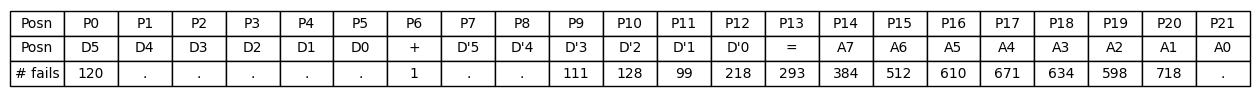

In [ ]:
print_config()
print()
print("num_questions=", num_questions, "min_useful_position=", min(ccfg.useful_positions), "max_useful_position=", max(ccfg.useful_positions) )
print()

columns = ["Posn"] + token_position_names
rows = ["Posn", "# fails"]
data = [
    ["Posn"] + token_position_meanings,
    ["# fails"] + num_failures_list
]

fig, ax = plt.subplots(figsize=(16,1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)  # Set the font size here
table.scale(1, 1.5)  # The first parameter scales column widths, the second scales row heights

plt.show()


# Part 14: Setup: Quanta results by node data structure

Evaluate quanta at node (not position) resolution. Uses "u_" prefix.

In [ ]:
class UsefulNode():
  # Position.Layer.Head of the node
  position: int  # token-position. Zero to cfg.n_ctx - 1
  layer: int
  head: int

  # Tags related to the node of form "MajorVersion.MinorVersion"
  tags: list


  # Is this node an attention head? If not, it must be an MLP layer
  def is_head(self):
    return self.head != cfg.n_heads


  def reset(self):
    self.position = -1
    self.layer = -1
    self.head = -1
    self.tags = []


  def name(self):
    return position_name(self.position)+"L"+str(self.layer)+"H"+str(self.head)


  # Remove some/all tags from this node
  def reset_tags(self, major_version):
    if major_version == "":
      self.tags = []
    else:
      self.tags = [s for s in self.tags if not s.startswith(major_version)]


  # Row in a table that this node is drawn
  def node_row(self):
    return quanta_row(self.layer, self.head)


  # Add a tag to this node (if not already present)
  def add_tag(self, major_tag, minor_tag):
    tag = major_tag + ":" + minor_tag
    if tag != "" and (not (tag in self.tags)):
      self.tags += [tag]


  # Return tags with the matching major
  def filter_tags(self, major_version):
    assert major_version != ""

    # Filter strings that start with the given major version
    filtered_strings = [s for s in self.tags if s.startswith(major_version)]

    # Extract minor versions
    minor_versions = [s.split(":")[1] for s in filtered_strings]

    return minor_versions


  # Return minimum tag with the matching major and minor versions
  def min_tag_suffix(self, major_version, minor_version):
    suffixes = self.filter_tags(major_version)

    if minor_version != "":
      suffixes = [s for s in suffixes if s.startswith(minor_version)]

    answer = min(suffixes) if suffixes else ""

    return answer


  # Return the only tag with the matching major_version
  def only_tag(self, major_version):
    assert major_version != ""

    filtered_strings = [s for s in self.tags if s.startswith(major_version)]

    num_strings = len(filtered_strings)
    if num_strings > 1:
      print("only_tag logic failure", major_version, num_strings, filtered_strings)
      assert False

    return filtered_strings[0].split(":")[1] if num_strings == 1 else ""


  # Return whether this node contains a tag with the matching major_version or major+minor_version
  def contains_tag(self, major, minor):
    assert major != ""

    for tag in self.tags:
      # We use contains(minor) as the POSITION_MAJOR_TAG minor tag is "P14=25%"
      if tag.startswith(major) and minor in tag:
        return True

    return False


  def to_dict(self):
    return {
      "position": self.position,
      "layer": self.layer,
      "head": self.head,
      "tags": self.tags
    }


  def __init__(self, position, layer, head, tags):
    self.position = position
    self.layer = layer
    self.head = head
    self.tags = tags

In [ ]:
def u_reset_tags( major_version = "" ):
  for node in ccfg.useful_nodes:
    node.reset_tags(major_version)


def u_get_node( the_row, the_position ):
  for node in ccfg.useful_nodes:
    if node.position == the_position and node.node_row() == the_row:
      return node

  return None


def u_add_node_tag( major_tag, minor_tag ):
  assert ccfg.curr_position  >= 0
  assert ccfg.curr_layer >= 0
  assert ccfg.curr_head >= 0
  assert ccfg.curr_position < cfg.n_ctx()
  assert ccfg.curr_layer < cfg.n_layers
  assert ccfg.curr_head <= cfg.n_heads

  the_row = quanta_row(ccfg.curr_layer, ccfg.curr_head)
  assert the_row >= 0

  the_node = u_get_node(the_row, ccfg.curr_position )
  if the_node == None:

    the_node = UsefulNode(ccfg.curr_position, ccfg.curr_layer, ccfg.curr_head, [])

    ccfg.useful_nodes += [the_node]

  the_node.add_tag(major_tag, minor_tag)

In [ ]:
  # Filter by a set of [Select/Deselect, major_tag, minor_tag ]
  # filter_heads(self, [[True, POSITION_MAJOR_TAG, P14],[True, IMPACT_MAJOR_TAG, A543], [False, ALGORITHM_MAJOR_TAG, D2.BA] ])
  def u_filter_heads(filters):
    answer = []
    for node in ccfg.useful_nodes:
      if node.is_head():
        include = True
        for filter in filters:
          select = filter[0]
          major = filter[1]
          minor = filter[2]
          if major == POSITION_MAJOR_TAG:
            include &= (select == (position_name(node.position) == minor))
          else:
            include &= (select == node.contains_tag(major,minor))
        if include:
          answer += [node]

    return answer

In [ ]:
def remove_duplicate_digits(input_string):
    seen = set()
    result = ""
    for char in input_string:
        if char not in seen:
            seen.add(char)
            result += char
    return result

# Unit test
assert remove_duplicate_digits("1231231278321") == "12378"

In [ ]:
def u_predict_questions(questions, the_hook):

  main_model.reset_hooks()
  main_model.set_use_attn_result(True)

  all_logits = main_model.run_with_hooks(questions.cuda(), return_type="logits", fwd_hooks=the_hook)
  all_losses_raw, all_max_prob_tokens = logits_to_tokens_loss(all_logits, questions.cuda())


  num_fails = 0
  impact_fails = ""
  add_complexity_fails = ""
  sub_complexity_fails = ""

  for question_num in range(questions.shape[0]):
    q = questions[question_num]

    the_loss_mean = utils.to_numpy(loss_fn(all_losses_raw[question_num]).mean())

    # Only show the question if the loss exceeds the threshold (because of the ablated token position)
    if the_loss_mean > ccfg.threshold:
      answer_str = tokens_to_string(all_max_prob_tokens[question_num])

      impact_str = get_answer_impact_meaning( q, answer_str )
      # Only count the question if the model got the question wrong
      if 'A' in impact_str:
        num_fails += 1

        impact_fails += impact_str

        complexity_major_tag, complexity_minor_tag = get_question_complexity(q)
        if complexity_major_tag == ADDITION_MAJOR_TAG:
          add_complexity_fails += complexity_minor_tag
        else:
          sub_complexity_fails += complexity_minor_tag

        if verbose :
          print(tokens_to_string(q), "U: ModelAnswer:", answer_str, "Complexity:", complexity_minor_tag, "Impact:", impact_str, "Loss:", the_loss_mean )


  if num_fails > 0:
    # Add percentage failure quanta
    perc = int( 100.0 * num_fails / len(questions))
    u_add_node_tag( FAIL_MAJOR_TAG, str(perc) )

    # Add summary of all answer digit impact quanta failures
    impact_digits = ''.join(filter(str.isdigit, impact_fails))
    impact_fails = "A" + ''.join(sorted(remove_duplicate_digits(impact_digits), reverse=True))
    u_add_node_tag( IMPACT_MAJOR_TAG, impact_fails )

    # Add summary of all addition question complexity quanta failures
    if add_complexity_fails != "":
      add_complexity_digits = ''.join(filter(str.isdigit, add_complexity_fails))
      add_complexity_fails = "S" + ''.join(sorted(remove_duplicate_digits(add_complexity_digits)))
      u_add_node_tag( ADDITION_MAJOR_TAG, add_complexity_fails )

    # Add summary of all subtraction question complexity quanta failures
    if sub_complexity_fails != "":
      sub_complexity_digits = ''.join(filter(str.isdigit, sub_complexity_fails))
      sub_complexity_fails = ''.join(sorted(remove_duplicate_digits(sub_complexity_digits)))
      if sub_complexity_fails == "":
        sub_complexity_fails = COMPLEXITY_NG_TAG
      else:
        sub_complexity_fails = "M" + sub_complexity_fails
      u_add_node_tag( SUBTRACTION_MAJOR_TAG, sub_complexity_fails )

    # Note that this row is useful (and should be shown in maps).
    ccfg.add_useful_row(quanta_row(ccfg.curr_layer, ccfg.curr_head))



In [ ]:
def u_mlp_hook_post(value, hook):
  #print( "In u_mlp_hook_post", value.shape) # Get [1, 22, 2040] = ???, cfg.n_ctx, cfg.d_mlp

  # Mean ablate. Copy the mean resid post values in position N to the MLP
  value[:,ccfg.curr_position,:] =  mean_mlp_hook_post[:,ccfg.curr_position,:].clone()


# Ablating the MLP in each layer in each position and seeing if the loss increases shows which head+layer+MLP are used by the algorithm.
def u_mlp_perform_all(questions):
  ccfg.curr_head = cfg.n_heads
  for ccfg.curr_position in ccfg.useful_positions:
    for ccfg.curr_layer in range(cfg.n_layers):
      the_hook = [(l_mlp_hook_post_name[ccfg.curr_layer], u_mlp_hook_post)]
      u_predict_questions(questions, the_hook)

In [ ]:
def u_head_attn_hook_z(value, hook):
  # print( "In u_head_attn_hook_z", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head

  # Mean ablate. Copy the mean resid post values in position N to all the batch questions
  value[:,ccfg.curr_position,ccfg.curr_head,:] = mean_attn_z[:,ccfg.curr_position,ccfg.curr_head,:].clone()


# Ablating each head in each layer in each position and seeing if the loss increases shows which position+layer+head are used by the algorithm.
def u_head_perform_all(questions):
  for ccfg.curr_position in ccfg.useful_positions:
    for ccfg.curr_layer in range(cfg.n_layers):
      for ccfg.curr_head in range(cfg.n_heads):
        the_hook = [(l_attn_hook_z_name[ccfg.curr_layer], u_head_attn_hook_z)]
        u_predict_questions(questions, the_hook)

In [ ]:
def h_null_attn_z_hook(value, hook):
  global verbose

  #print("In h_null_attn_z_hook", value.shape)  # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head


# We store a maximum of 5 attention tags per node
MAX_ATTENTION_TAGS = 5


def u_calculate_attention_tags(questions):
  u_reset_tags(ATTENTION_MAJOR_TAG)

  logits, cache = main_model.run_with_cache(questions)

  all_attention_weights = []
  for layer in range(cfg.n_layers):
    attention_weights = cache["pattern", layer, "attn"]
    #print(attention_weights.shape) # 512, 4, 22, 22 = cfg.batch_size, cfg.n_heads, cfg.n_ctx, cfg.n_ctx

    average_attention_weights = attention_weights.mean(dim=0)
    #print(average_attention_weights.shape) # 4, 22, 22 = cfg.n_heads, cfg.n_ctx, cfg.n_ctx

    all_attention_weights += [average_attention_weights]


  for node in ccfg.useful_nodes:
    if node.is_head():
      # Get attention weights for this token in this head
      layer_weights = all_attention_weights[node.layer]
      weights = layer_weights[node.head, node.position, :]

      top_tokens = torch.topk(weights, 4)
      total_attention = weights.sum()
      attention_percentage = top_tokens.values / total_attention * 100

      # Add up to 4 tags with percs per head
      for idx, token_idx in enumerate(top_tokens.indices):
        perc = attention_percentage[idx]
        if perc >= 1.0:
          ccfg.curr_position = node.position
          ccfg.curr_layer = node.layer
          ccfg.curr_head = node.head
          u_add_node_tag( ATTENTION_MAJOR_TAG, f"P{token_idx}={perc:.0f}" )

In [ ]:
verbose = False
ccfg.useful_nodes = []
u_mlp_perform_all(varied_questions)
u_head_perform_all(varied_questions)
u_calculate_attention_tags(varied_questions)

 # Part 15A: Set up: Quanta 2D map

In [ ]:
# Define a colormap for use with graphing
def create_custom_colormap():
    colors = ["green", "yellow"]
    return mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)


# Blend the color with white to make it paler
def pale_color(color, factor=0.5):
    color_array = np.array(color)
    white = np.array([1, 1, 1, 1])
    return white * factor + color_array * (1 - factor)

In [ ]:
class quanta_result:
  model_row : int = 0
  model_col : int = 0
  cell_text : str = ""
  color_index :int = -1


  def __init__(self, model_row, model_col, cell_text, color_index):
    self.model_row = model_row
    self.model_col = model_col
    self.cell_text = cell_text
    self.color_index = color_index


def calc_quanta_results( major_version, minor_version, get_node_details, shades ):

  quanta_results = []

  for raw_row in ccfg.useful_rows:
    for raw_col in ccfg.useful_positions:
      node = u_get_node(raw_row, raw_col)
      if node != None:
        cell_text, color_index = get_node_details(node, major_version, minor_version, shades)
        if cell_text != "" :
          quanta_results +=[quanta_result(model_row=raw_row, model_col=raw_col, cell_text=cell_text, color_index=color_index )]

  return quanta_results


def find_quanta_result_by_row_col(row, col, quanta_results):
    for result in quanta_results:
        if result.model_row == row and result.model_col == col:
            return result
    return None

In [ ]:
def show_quanta_add_patch(ax, j, row, cell_color):
  ax.add_patch(plt.Rectangle((j, row), 1, 1, fill=True, color=cell_color))


def show_quanta_map( title, custom_cmap, shades, major_version, minor_version, get_node_details, base_fontsize = 10, max_width = 10):

  quanta_results = calc_quanta_results(major_version, minor_version, get_node_details, shades)

  distinct_rows = set()
  distinct_cols = set()

  for result in quanta_results:
      distinct_rows.add(result.model_row)
      distinct_cols.add(result.model_col)

  distinct_rows = sorted(distinct_rows)
  distinct_cols = sorted(distinct_cols)

  print_config()
  print()

  # Create figure and axes
  fig1, ax1 = plt.subplots(figsize=(2*len(distinct_cols)/3, 2*len(distinct_rows)/3))  # Adjust the figure size as needed

  # Ensure cells are square
  ax1.set_aspect('equal', adjustable='box')
  ax1.yaxis.set_tick_params(labelleft=True, labelright=False)

  colors = [pale_color(custom_cmap(i/shades)) for i in range(shades)]
  vertical_labels = []
  horizontal_labels = []
  wrapper = textwrap.TextWrapper(width=max_width)


  show_row = len(distinct_rows)-1
  for raw_row in distinct_rows:
    vertical_labels += [get_quanta_row_heading(raw_row)]

    show_col = 0
    for raw_col in distinct_cols:
      cell_color = 'lightgrey'  # Color for empty cells

      if show_row == 0:
        horizontal_labels += [token_position_meanings[raw_col]]

      result = find_quanta_result_by_row_col(raw_row, raw_col, quanta_results)
      if result != None:
        cell_color = colors[result.color_index] if result.color_index >= 0 else 'lightgrey'
        the_fontsize = base_fontsize if len(result.cell_text) < 4 else base_fontsize-1 if len(result.cell_text) < 5 else base_fontsize-2
        wrapped_text = wrapper.fill(text=result.cell_text)
        ax1.text(show_col + 0.5, show_row + 0.5, wrapped_text, ha='center', va='center', color='black', fontsize=the_fontsize)

      show_quanta_add_patch(ax1, show_col, show_row, cell_color)
      show_col += 1

    show_row -= 1


  # Configure x axis
  ax1.set_xlim(0, len(horizontal_labels))
  ax1.set_xticks(np.arange(0.5, len(horizontal_labels), 1))
  ax1.set_xticklabels(horizontal_labels)
  ax1.xaxis.tick_top()
  ax1.xaxis.set_label_position('top')
  ax1.tick_params(axis='x', length=0)
  for label in ax1.get_xticklabels():
    label.set_fontsize(9)

  # Configure y axis
  vertical_labels = vertical_labels[::-1] # Reverse the order
  ax1.set_ylim(0, len(vertical_labels))
  ax1.set_yticks(np.arange(0.5, len(vertical_labels), 1))
  ax1.set_yticklabels(vertical_labels)
  ax1.tick_params(axis='y', length=0)
  for label in ax1.get_yticklabels():
    label.set_horizontalalignment('left')
    label.set_position((-0.1, 0))  # Adjust the horizontal position

  fulltitle = op_prefix + ': ' + title + ' d{}_l{}_h{}'.format(cfg.n_digits, cfg.n_layers, cfg.n_heads)

  if cfg.save_graph_to_file:
    print("Saving quanta map:", fulltitle)
    filename = fulltitle.replace( ' ', '_').replace( '-', '_').replace( ':', '_')
    plt.savefig(filename+".pdf", bbox_inches='tight', pad_inches=0)
  else:
    ax1.set_title(fulltitle + ' ({} nodes)'.format(len(quanta_results)))

  # Show plot
  plt.show()

# Part 16A: Results: Show failure percentage quanta map

Show the percentage failure rate (incorrect prediction) when individual Attention Heads and MLPs are ablated.

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Complexity.Varied d6_l3_h4


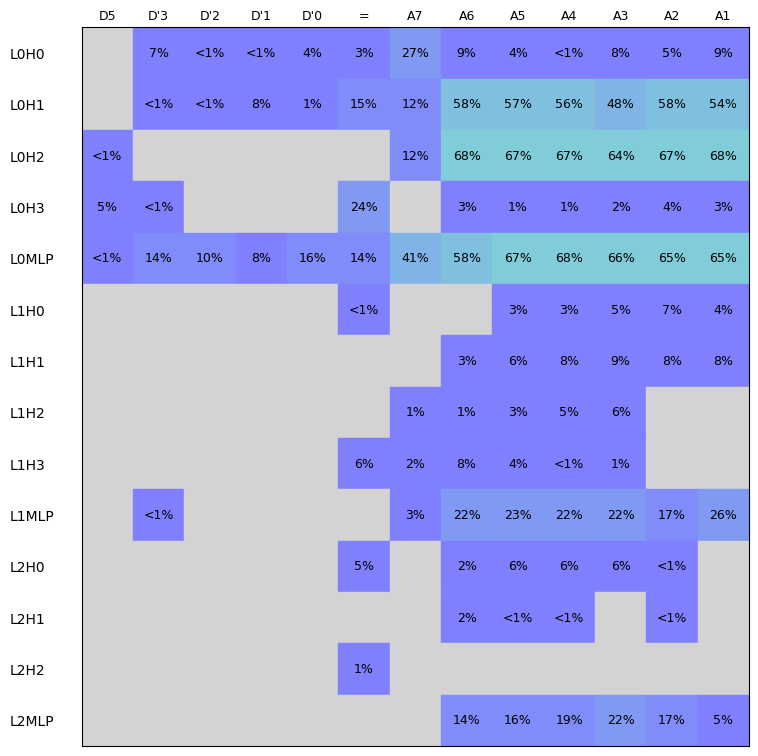

In [ ]:
def get_quanta_fail_percs( node, major_version, minor_version, shades):
  cell_text = node.only_tag( major_version )
  value = int(cell_text) if cell_text != "" else 0

  if value == 100 and ccfg.num_compressed_cols() > 5:
    value = 99 # Avoid overlapping figures in the matrix.
  color_index = value // shades
  cell_text = (str(value) if value > 0 else "<1") + "%"

  return cell_text, color_index


show_quanta_map( VARIED_MAJOR_TAG, plt.cm.winter, 10, FAIL_MAJOR_TAG, "", get_quanta_fail_percs, 9)

# Part 16B: Result: Show attention quanta map

Show attention quanta of useful cells

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Attention per node d6_l3_h4


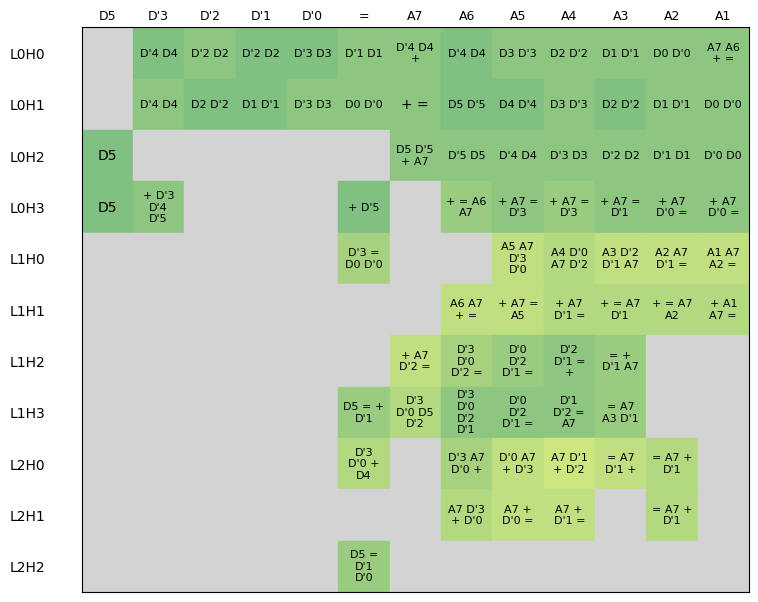

In [ ]:
MIN_ATTENTION_PERC = 1 # Only show input tokens with >= 1% of attention


# Only maps attention heads, not MLP layers
def get_quanta_attention_tag(node, major_version, minor_version, shades):
  cell_text = ""
  color_index = 0

  if node.is_head():
    sum_perc = 0
    node_tags = node.filter_tags( major_version )
    for minor_version in node_tags:
      node_parts = minor_version.split("=")
      token_pos = int(node_parts[0][1:]) # Strip off the "P"
      the_perc = int(node_parts[1])
      if the_perc >= MIN_ATTENTION_PERC:
        cell_text += token_position_meanings[token_pos] + " "
        sum_perc += the_perc

    cell_text = cell_text.rstrip(" ")
    color_index = shades - sum_perc // shades    # Want >90% => Dark-Green, and <10% => Yellow

    if len(node_tags) == MAX_ATTENTION_TAGS:
      # Number of input tokens that node attended to could be > MAX_ATTENTION_TAGS so show yellow
      color_index = shades-1

  return cell_text, color_index


# Only maps attention heads, not MLP layers
show_quanta_map( "Attention per node", create_custom_colormap(), 10, ATTENTION_MAJOR_TAG, "", get_quanta_attention_tag, 10, 6)

# Part 16C - Show question complexity (S*) quanta map

Show the "minimum" addition purpose of each useful cell by S0 to S5 quanta.
Show the "minimum" subtraction purpose of each useful cell by M0 to M5 quanta

In [ ]:
def get_quanta_min_tag(node, major_version, minor_version, shades):
  color_index = 0
  cell_text = node.min_tag_suffix( major_version, minor_version )
  if cell_text != "" :
    cell_text = cell_text[0:2]
    color_index = int(cell_text[1]) if len(cell_text) > 1 and cell_text[1].isdigit() else shades-1

  return cell_text, color_index


def draw_quanta_min_tags( title, major_version, minor_version, shades):
  show_quanta_map( title, create_custom_colormap(), shades, major_version, minor_version, get_quanta_min_tag)

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Addition min-complexity per node d6_l3_h4


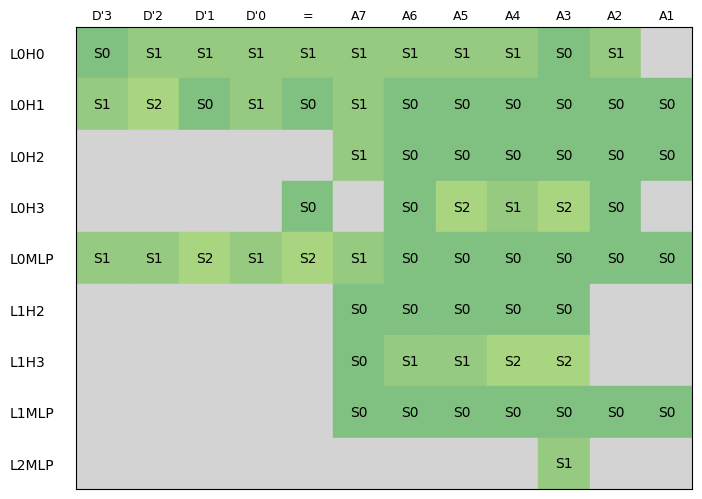

In [ ]:
if cfg.perc_add() > 0:
  draw_quanta_min_tags( "Addition min-complexity per node", ADDITION_MAJOR_TAG, "", 6)

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Subtraction min-complexity per node d6_l3_h4


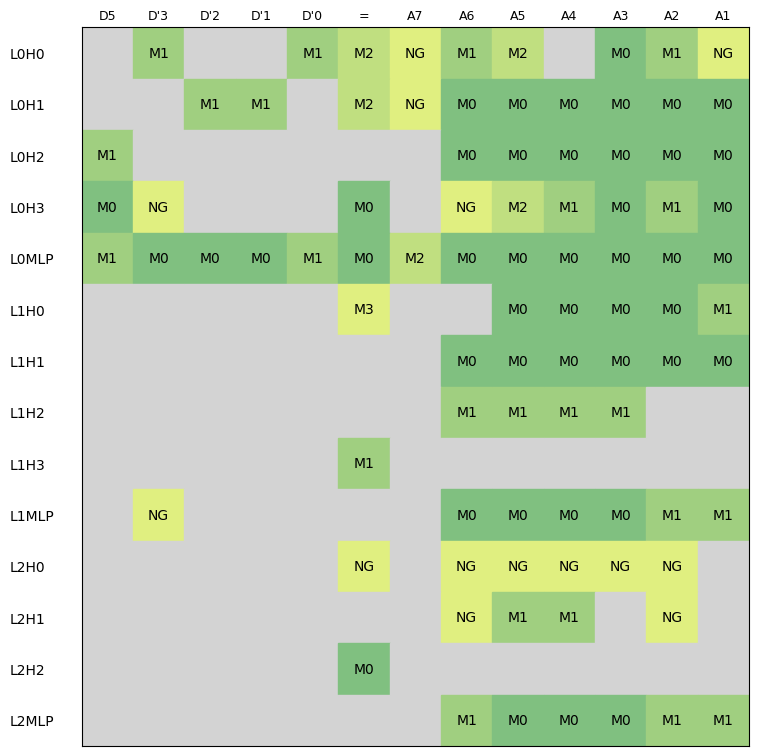

In [ ]:
if cfg.perc_sub > 0:
  draw_quanta_min_tags( "Subtraction min-complexity per node", SUBTRACTION_MAJOR_TAG, "", 4)

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Neg-answer subtraction min-complexity per node d6_l3_h4


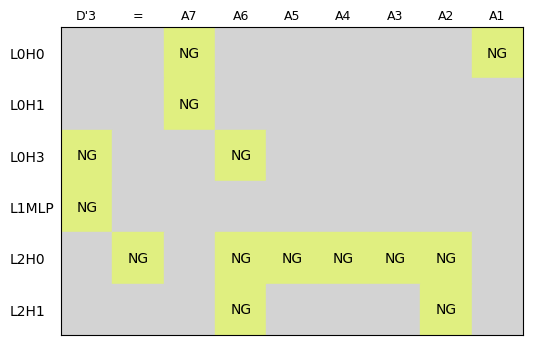

In [ ]:
if cfg.perc_sub > 0:
  draw_quanta_min_tags( "Neg-answer subtraction min-complexity per node", SUBTRACTION_MAJOR_TAG, COMPLEXITY_NG_TAG, 4)

# Part 16D - Show answer impact quanta map

Show the purpose of each useful cell by impact on the answer digits A0 to A5.


In [ ]:
# Check if the digits in the string are sequential
def is_sequential(digits):
  return all(ord(next_char) - ord(current_char) == -1 for current_char, next_char in zip(digits, digits[1:]))


# Convert A654321 to A6..1 for compact display
def compact_display_if_sequential(s):
    if len(s) > 3:
      letter, digits = s[0], s[1:]
      if is_sequential(digits):
        # Convert to compact form if digits are sequential
        return f"{letter}{digits[0]}..{digits[-1]}"

    # Return original string if not sequential
    return s


# Unit test
assert compact_display_if_sequential("A654321") == "A6..1"

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Answer impact per node d6_l3_h4


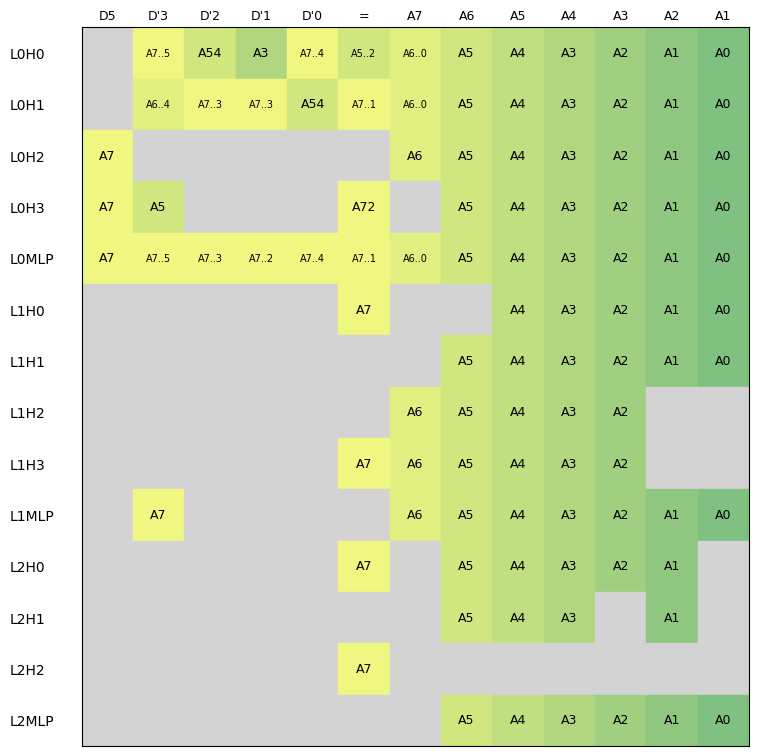

In [ ]:
def get_impact_quanta_range( node, major_version, minor_version, shades):

  cell_text = ""
  color_index = 0

  cell_text = node.min_tag_suffix( major_version, minor_version )
  if len(cell_text) > 0:
    cell_text = compact_display_if_sequential(cell_text)

    color_index = int(cell_text[1]) if len(cell_text) > 1 and cell_text[1].isdigit() else shades-1

  return cell_text, color_index


show_quanta_map( "Answer impact per node", create_custom_colormap(), cfg.n_digits+2, IMPACT_MAJOR_TAG, "", get_impact_quanta_range, 9)

#Part 18: Set Up: Calc and graph PCA decomposition

In [ ]:
tn_questions = 100


def make_t_questions(test_digit, test_case, operation):
    limit = 10 ** test_digit
    questions = []
    for i in range(tn_questions):


      if operation == PLUS_INDEX:
        if test_case == 8:
          # These are n_digit addition questions where the first test_digits add up from 0 to 8
          x = random.randint(0, 8)
          y = random.randint(0, 8-x)
        if test_case == 9:
          # These are n_digit addition questions where the first test_digits add up to 9
          x = random.randint(0, 9)
          y = 9 - x
        if test_case == 10:
          # These are n_digit addition questions where the first test_digits add up to 10 to 18
          x = random.randint(1, 9)
          y = random.randint(10-x, 9)


      if operation == MINUS_INDEX:
        if test_case == 8:
          # These are n_digit subtraction questions where the first test_digits difference is negative
          x = random.randint(0, 8)
          y = random.randint(x+1, 9)
        if test_case == 9:
          # These are n_digit subtraction questions where the first test_digits difference is zero
          x = random.randint(0, 9)
          y = x
        if test_case == 10:
          # These are n_digit subtraction questions where the first test_digits difference is positive
          x = random.randint(0, 9)
          y = random.randint(0, x-1)


      # Randomise the last test_digits-1 digits of both numbers
      x = x * limit + random.randint(0, limit-1)
      y = y * limit + random.randint(0, limit-1)
      questions.append([x, y])
    return make_questions(operation, questions)



def make_tricase_questions(test_digit, operation):
  q1 = make_t_questions(test_digit, 8, operation)
  q2 = make_t_questions(test_digit, 9, operation)
  q3 = make_t_questions(test_digit, 10, operation)

  questions = torch.vstack((q1, q2, q3))

  return questions

In [ ]:
# Do one Principal Component Analysis
def calc_tricase_pca(t_position, t_layer, t_head, t_digit, operation):
  global tn_questions

  t_questions = make_tricase_questions(t_digit, operation)

  t_logits, t_cache = main_model.run_with_cache(t_questions)

  # Gather attention patterns for all the (randomly chosen) questions
  attention_outputs = []
  for i in range(len(t_questions)):

    # Output of individual heads, without final bias
    attention_cache=t_cache["result", t_layer, "attn"] # Output of individual heads, without final bias
    attention_output=attention_cache[i]  # Shape [n_ctx, n_head, d_model]
    attention_outputs.append(attention_output[t_position, t_head, :])

  attn_outputs = torch.stack(attention_outputs, dim=0).cpu()

  pca = PCA(n_components=6)
  pca.fit(attn_outputs)
  pca_attn_outputs = pca.transform(attn_outputs)

  title = 'P' + str(t_position) + 'L' + str(t_layer) + 'H'+str(t_head) + ', A'+str(t_digit) + ', EVR[0]=' + str(int(round(pca.explained_variance_ratio_[0]*100,0))) + '%'

  return (pca, pca_attn_outputs, title)


# Plot one PCA scatter graph
def graph_pca(pca, pca_attn_outputs, ax, title):
  global tn_questions

  ax.scatter(pca_attn_outputs[:tn_questions, 0], pca_attn_outputs[:tn_questions, 1], color='red', label='T8 (0-8)') # t8 questions
  ax.scatter(pca_attn_outputs[tn_questions:2*tn_questions, 0], pca_attn_outputs[tn_questions:2*tn_questions, 1], color='green', label='T9') # t9 questions
  ax.scatter(pca_attn_outputs[2*tn_questions:, 0], pca_attn_outputs[2*tn_questions:, 1], color='blue', label='T10 (10-18)') # t10 questions

  if title != "" :
    ax.set_title(title)

In [ ]:
# Graph the PCA of Pasn.Ln.Hn's attention pattern, using T8, T9, T10 questions that differ in the An digit
def add_one_pca_subplot(ax, t_position, t_layer, t_head, t_digit, operation):
  try:
    pca, pca_attn_outputs, title = calc_tricase_pca(t_position, t_layer, t_head, t_digit, operation)
    graph_pca( pca, pca_attn_outputs, ax, title)
  except Exception as e:
    desc = "add_one_pca_subplot(P" + str(t_position) + "L"+ str(t_layer) + "H"+ str(t_head) + " D"+ str(t_digit) + " "+ str(operation) + ")"
    print( desc + " Failed:", e)

In [ ]:
def save_plt_to_file( full_title ):
  if cfg.save_graph_to_file:
    filename = full_title.replace(" ", "_").replace(",", "").replace(":", "_")  + '.pdf'
    plt.savefig(filename)

#Part 19: Results: add_d6_l2_h3_train15K PCA decomposition tri-state results

Plot attention heads in the positions 8 to 16 with a clear "tri-state" response to (exactly) one An.

In [ ]:
if not use_pca:
  print( "PCA library failed to import. So PCA not done")

if use_pca and (model_name == "add_d5_l2_h3_train15K" or model_name == "add_d6_l2_h3_train15K"):
  op = PLUS_INDEX


  if model_name == "add_d5_l2_h3_train15K" :
    fig, axs = plt.subplots(4, 2)
    fig.set_figheight(8)
    fig.set_figwidth(5)

    # Plot all useful attention heads in the positions 8 to 14 with the clearest An selected
    add_one_pca_subplot(axs[0, 0], 8, 0, 1, 2, op)    # P8.L0.H1 is interpretable only for A2
    add_one_pca_subplot(axs[0, 1], 9, 0, 1, 1, op)    # P9.L0.H1 is interpretable only for A1
    add_one_pca_subplot(axs[1, 0], 11, 0, 1, 3, op)   # P11.L0.H1 is interpretable only for A3
    add_one_pca_subplot(axs[1, 1], 11, 0, 2, 4, op)   # P11.L0.H2 is interpretable only for A4
    add_one_pca_subplot(axs[2, 0], 12, 0, 1, 3, op)   # P12.L0.H1 is interpretable only for A3
    add_one_pca_subplot(axs[2, 1], 13, 0, 1, 2, op)   # P13.L0.H1 is interpretable only for A2
    add_one_pca_subplot(axs[3, 0], 14, 0, 1, 1, op)   # P14.L0.H1 is interpretable only for A1

    lines_labels = [axs[0,0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc='lower center', ncol=4)
    # fig.subplots_adjust(bottom=0.2)  # Adjust the bottom spacing
    axs[3, 1].legend(lines, labels)
    axs[3, 1].axis('off') # Now, to hide the last subplot


  if model_name == "add_d6_l2_h3_train15K" :
    fig, axs = plt.subplots(5, 2)
    fig.set_figheight(8)
    fig.set_figwidth(5)

    # Plot all useful attention heads in the positions 11 to 16 with the clearest An selected
    add_one_pca_subplot(axs[0, 0], 11, 0, 0, 2, op)   # P11.L0.H0 is interpretable only for A2
    add_one_pca_subplot(axs[0, 1], 12, 0, 0, 3, op)   # P12.L0.H0 is interpretable only for A3
    add_one_pca_subplot(axs[1, 0], 13, 0, 0, 1, op)   # P13.L0.H0 is interpretable only for A1
    add_one_pca_subplot(axs[1, 1], 14, 0, 0, 4, op)   # P14.L0.H0 is interpretable only for A4
    add_one_pca_subplot(axs[2, 0], 14, 1, 1, 4, op)   # P14.L1.H1 is interpretable only for A4
    add_one_pca_subplot(axs[2, 1], 15, 0, 0, 4, op)   # P15.L0.H0 is interpretable only for A4
    add_one_pca_subplot(axs[3, 0], 15, 1, 1, 4, op)   # P15.L1.H1 is interpretable only for A4
    add_one_pca_subplot(axs[3, 1], 15, 1, 2, 4, op)   # P15.L1.H2 is interpretable only for A4
    add_one_pca_subplot(axs[4, 0], 17, 0, 0, 2, op)   # P16.L0.H0 is interpretable only for A5

    lines_labels = [axs[0,0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc='lower center', ncol=4)
    # fig.subplots_adjust(bottom=0.2)  # Adjust the bottom spacing
    axs[4, 1].legend(lines, labels)
    axs[4, 1].axis('off') # Now, to hide the last subplot


  plt.tight_layout()
  save_plt_to_file('PCA_Trigrams')
  plt.show()

PCA library failed to import. So PCA not done


#Part 19B: Results: add_d6_l2_h3_train15K PCA decomposition bi-state results

Plot attention heads in the positions 8 to 16 with a clear "bi-state" response to (exactly) one An.


In [ ]:
if not use_pca:
  print( "PCA library failed to import. So PCA not done")

if use_pca and model_name == "add_d5_l2_h3_train15K" :
  op = PLUS_INDEX

  fig, axs = plt.subplots(1, 2)
  fig.set_figheight(2)
  fig.set_figwidth(5)

  # Plot all useful attention heads in the positions 8 to 12 with the clearest An selected
  add_one_pca_subplot(axs[0], 10, 0, 1, 0, op)   # P10.L0.H1 is clear only for A0
  add_one_pca_subplot(axs[1], 15, 0, 1, 0, op)   # P15.L0.H1 is clear only for A0

  lines_labels = [axs[0].get_legend_handles_labels()]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels, loc='lower center', ncol=4)

  plt.tight_layout()
  save_plt_to_file('PCA_Bigrams')
  plt.show()

PCA library failed to import. So PCA not done


#Part 19C: Results: PCA decomposition of useful cells

Parts 19A and 19B are selective. This part is not. Use it to find (verify) the interesting parts.

In [ ]:
def graph_all_pca_results(op):
  for node in ccfg.useful_nodes:
    if node.is_head():
      print( "PCA: " + node.name())

      fig, axs = plt.subplots(4, 2)

      add_one_pca_subplot(axs[0, 0], node.position, node.layer, node.head, 0, op)
      add_one_pca_subplot(axs[0, 1], node.position, node.layer, node.head, 1, op)
      add_one_pca_subplot(axs[1, 0], node.position, node.layer, node.head, 2, op)
      add_one_pca_subplot(axs[1, 1], node.position, node.layer, node.head, 3, op)
      add_one_pca_subplot(axs[2, 0], node.position, node.layer, node.head, 4, op)
      add_one_pca_subplot(axs[2, 1], node.position, node.layer, node.head, 5, op)
      add_one_pca_subplot(axs[3, 0], node.position, node.layer, node.head, 6, op)
      add_one_pca_subplot(axs[3, 1], node.position, node.layer, node.head, 7, op)

      plt.tight_layout()
      plt.show()


if use_pca and model_name == "add_d6_l2_h3_train15K" :

  if cfg.perc_add() > 0:
    graph_all_pca_results(PLUS_INDEX)
  if cfg.perc_sub > 0:
    graph_all_pca_results(MINUS_INDEX)

# Part 20: Results: Show useful nodes and behaviour tags

In [ ]:
ccfg.useful_nodes = sorted(ccfg.useful_nodes, key=lambda obj: (obj.position, obj.layer, obj.head))


In [ ]:
ccfg.print_node_tags()

P0L0H2 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:M1', 'Attn:P0=100']
P0L0H3 ['FailPerc:5', 'Impact:A7', 'Complexity.Sub:M013', 'Attn:P0=100']
P0L0H4 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:M13']
P9L0H0 ['FailPerc:7', 'Impact:A765', 'Complexity.Add:S01234', 'Complexity.Sub:M13', 'Attn:P8=53', 'Attn:P1=47']
P9L0H1 ['FailPerc:0', 'Impact:A654', 'Complexity.Add:S124', 'Attn:P8=53', 'Attn:P1=46']
P9L0H3 ['FailPerc:0', 'Impact:A5', 'Complexity.Sub:NG', 'Attn:P6=79', 'Attn:P9=7', 'Attn:P8=4', 'Attn:P7=3']
P9L0H4 ['FailPerc:14', 'Impact:A765', 'Complexity.Add:S12345', 'Complexity.Sub:M0123']
P9L1H4 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:NG']
P10L0H0 ['FailPerc:0', 'Impact:A54', 'Complexity.Add:S13', 'Attn:P10=51', 'Attn:P3=48']
P10L0H1 ['FailPerc:0', 'Impact:A76543', 'Complexity.Add:S234', 'Complexity.Sub:M12', 'Attn:P3=50', 'Attn:P10=50']
P10L0H4 ['FailPerc:10', 'Impact:A76543', 'Complexity.Add:S12345', 'Complexity.Sub:M012']
P11L0H0 ['FailPerc:0', 'Impact:A3', 'Complexity.Add:S12'

# Part 21A : Set up: Interchange Interventions

Here we prove that model nodes perform specified calculations. If all the calculations in an algorithm hypothesis are found to exist in a model instance, this provides evidence for the hypothesis.   

**Automatic searches** for node purposes are preferred, as they applicable to several models, and survive (non-sigificant, node-reordering) changes to the model after training. When a node purpose is detected, this is documented as a tag on the node.

**Manually written tests** of node purposes, specific to a single model instance are also supported.

In [ ]:
class A_Config():
  # A list of nodes to test. Each node is a list with three values [position, layer, head]
  # An example list is [[11,0,0], [11,0,1]]
  nodes = []

  # A list of stored weightings collected from the model.
  # Same length as nodes
  layer_store = []

  questions = []
  null_hooks = []
  get_hooks = []
  put_hooks = []


  def reset(self):
    self.nodes = []
    self.layer_store = [[],[],[]]   # Supports 3 layers
    self.questions = []
    self.null_hooks = []
    self.get_hooks = []
    self.put_hooks = []

    ccfg.curr_position = 0
    ccfg.curr_layer = 0
    ccfg.curr_heads = 0
    ccfg.threshold = 0.00001


  def node_name(self, index):
    return position_name(self.nodes[index][0]) + "L" + str(self.nodes[index][1]) + "H" + str(self.nodes[index][2])


  def node_names(self):
    answer = ""

    for index in range(len(acfg.nodes)):
      if answer != "":
        answer += ", "
      answer += acfg.node_name(index)

    return answer


acfg = A_Config()
acfg.reset()

In [ ]:
# Get and put attention head value hooks

def a_null_attn_z_hook(value, hook):
  global acfg

  #print("In a_null_attn_z_hook", value.shape)  # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head


def a_get_l0_attn_z_hook(value, hook):
  # print( "In a_get_l0_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
  acfg.layer_store[0] = value.clone()

def a_get_l1_attn_z_hook(value, hook):
  # print( "In acfg.get_l1_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
  acfg.layer_store[1] = value.clone()

def a_get_l2_attn_z_hook(value, hook):
  # print( "In acfg.get_l2_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
  acfg.layer_store[2] = value.clone()


def a_put_l0_attn_z_hook(value, hook):
  # print( "In a_l0_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head
  for location in acfg.nodes:
    if location[1] == 0:
      value[:,location[0],location[2],:] = acfg.layer_store[0][:,location[0],location[2],:].clone()

def a_put_l1_attn_z_hook(value, hook):
  # print( "In a_l1_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head
  for location in acfg.nodes:
    if location[1] == 1:
      value[:,location[0],location[2],:] = acfg.layer_store[0][:,location[0],location[2],:].clone()

def a_put_l2_attn_z_hook(value, hook):
  # print( "In a_l2_attn_z_hook", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, d_head
  for location in acfg.nodes:
    if location[1] == 2:
      value[:,location[0],location[2],:] = acfg.layer_store[0][:,location[0],location[2],:].clone()


def a_reset(nodes):
  acfg.reset()
  acfg.nodes = nodes
  acfg.null_hooks = [(l_attn_hook_z_name[0], a_null_attn_z_hook)]
  acfg.get_hooks = [(l_attn_hook_z_name[0], a_get_l0_attn_z_hook)]
  acfg.put_hooks = [(l_attn_hook_z_name[0], a_put_l0_attn_z_hook)]
  if cfg.n_layers >= 2:
    acfg.null_hooks += [(l_attn_hook_z_name[1], a_null_attn_z_hook)]
    acfg.get_hooks += [(l_attn_hook_z_name[1], a_get_l1_attn_z_hook)]
    acfg.put_hooks += [(l_attn_hook_z_name[1], a_put_l1_attn_z_hook)]
  if cfg.n_layers >= 3:
    acfg.null_hooks += [(l_attn_hook_z_name[2], a_null_attn_z_hook)]
    acfg.get_hooks += [(l_attn_hook_z_name[2], a_get_l2_attn_z_hook)]
    acfg.put_hooks += [(l_attn_hook_z_name[2], a_put_l2_attn_z_hook)]

In [ ]:
def a_predict_question(description, the_hooks):
  assert len(acfg.questions) == 1

  main_model.reset_hooks()
  main_model.set_use_attn_result(True)

  all_logits = main_model.run_with_hooks(acfg.questions.cuda(), return_type="logits", fwd_hooks=the_hooks)
  all_losses_raw, all_max_prob_tokens = logits_to_tokens_loss(all_logits, acfg.questions.cuda())

  loss_max = utils.to_numpy(loss_fn(all_losses_raw[0]).max())
  answer_str = tokens_to_string(all_max_prob_tokens[0])

  # Compare the question answer (ignoring the ablation intervention) to what the model generated (which is impacted by the ablation intervention)
  impact_str = get_answer_impact_meaning( acfg.questions[0], answer_str )
  if impact_str == "":
    impact_str = NO_IMPACT_TAG

  full_description = description
  if loss_max > ccfg.threshold:
    loss_str = NO_IMPACT_TAG if loss_max < 1e-7 else str(loss_max)

    full_description = description + "  ModelPredicts: " + answer_str + "  DigitsImpacted: " + impact_str + "  Loss: " + loss_str

  return answer_str, impact_str, full_description

In [ ]:
def a_run_intervention_core(nodes, store_question, alter_question, operation = PLUS_INDEX):
  a_reset(nodes)

  # Predict first question and store activation values
  acfg.questions = make_questions(operation, [store_question])
  a_predict_question("Unit test (null hook)", acfg.null_hooks)
  a_predict_question("Store activation", acfg.get_hooks)

  # Predict second question. Then rerun overriding PnLmHp to give bad answer
  acfg.questions = make_questions(operation, [alter_question])
  a_predict_question("Unit test (null hook)", acfg.null_hooks)
  prompt = "Intervening on " + acfg.node_names()
  return a_predict_question(prompt, acfg.put_hooks)


# Run an intervention where we expect the intervention to succeed. Report failures.
def run_intervention(nodes, store_question, alter_question, expected_impact, expected_answer_int, show_failures = True):

    answer_str, impact_str, full_description = a_run_intervention_core(nodes, store_question, alter_question)

    if expected_impact == "":
      expected_impact = NO_IMPACT_TAG
    expected_answer = int_to_answer_str(expected_answer_int)

    success = (impact_str == expected_impact) and (answer_str == expected_answer)
    if show_failures and not success:
      print( full_description )
      print("Failed (prediction/expected):", impact_str, expected_impact, answer_str, expected_answer)

    return success, answer_str, full_description

In [ ]:
u_reset_tags(ALGORITHM_MAJOR_TAG)

# Part 21C: Automated Dn.BA search

The addition Base Add (BA) operation is a simple task implemented in late attention head(s). The task may be split/shared over 2 attention heads. Search for BA calculations.

In [ ]:
def repeat_digit(digit):
    return int(str(digit) * cfg.n_digits)


# unit test
if cfg.n_digits == 6:
  assert repeat_digit(4) == 444444

In [ ]:
def test_ba(nodes, alter_digit, expected_impact):
  acfg.nodes = nodes
  description = acfg.node_names() + " perform D"+str(alter_digit)+".BA = (D"+str(alter_digit)+" + D"+str(alter_digit)+"') % 10 impacting "+expected_impact+" accuracy"

  store_question = [repeat_digit(2), repeat_digit(3)] # 222222 + 333333 = 555555
  alter_question = [repeat_digit(5), repeat_digit(4)] # 555555 + 444444 = 999999
  expected_answer1 = repeat_digit(9) + (5 - 9) * (10 ** alter_digit)
  success1, _, _ = run_intervention(nodes, store_question, alter_question, expected_impact, expected_answer1, False)

  store_question = [repeat_digit(2), repeat_digit(1)] # 222222 + 111111 = 333333
  alter_question = [repeat_digit(5), repeat_digit(4)] # 555555 + 444444 = 999999
  expected_answer2 = int(repeat_digit(9)) + (3 - 9) * (10 ** alter_digit)
  success2, _, _ = run_intervention(nodes, store_question, alter_question, expected_impact, expected_answer2, False)

  if success1 and success2:
    print( "Test confirmed:", description)

  return success1 and success2

In [ ]:
def algorithm_ba_tag(the_digit):
  return answer_name(the_digit)  + "." + ALGORITHM_BA_TAG


if cfg.perc_add() > 0:
  for impact_digit in range(cfg.n_digits):

    heads = u_filter_heads( [
      [True, POSITION_MAJOR_TAG, an_to_position_name(impact_digit+1)], # Calculated one position before needed
      [True, ATTENTION_MAJOR_TAG, dn_to_position_name(impact_digit)], # Attends to Dn
      [True, ATTENTION_MAJOR_TAG, ddn_to_position_name(impact_digit)], # Attends to D'n
      [True, IMPACT_MAJOR_TAG, answer_name(impact_digit)]] ) # Impacts An
    ba_tag = algorithm_ba_tag(impact_digit)

    # Try single nodes first
    for node in heads:
      if test_ba( [[node.position, node.layer, node.head]], impact_digit, answer_name(impact_digit)):
        node.add_tag(ALGORITHM_MAJOR_TAG, ba_tag)

    # Try pairs of nodes
    node_pairs = list(itertools.combinations(heads, 2))
    for pair in node_pairs:
        if test_ba( [[pair[0].position, pair[0].layer, pair[0].head],[pair[1].position, pair[1].layer, pair[1].head]], impact_digit, answer_name(impact_digit)):
          pair[0].add_tag(ALGORITHM_MAJOR_TAG, ba_tag)
          pair[1].add_tag(ALGORITHM_MAJOR_TAG, ba_tag)

Test confirmed: P20L0H1, P20L0H2 perform D0.BA = (D0 + D0') % 10 impacting A0 accuracy
Test confirmed: P19L0H1, P19L0H2 perform D1.BA = (D1 + D1') % 10 impacting A1 accuracy
Test confirmed: P18L0H1, P18L0H2 perform D2.BA = (D2 + D2') % 10 impacting A2 accuracy
Test confirmed: P17L0H1, P17L0H2 perform D3.BA = (D3 + D3') % 10 impacting A3 accuracy
Test confirmed: P16L0H1, P16L0H2 perform D4.BA = (D4 + D4') % 10 impacting A4 accuracy
Test confirmed: P15L0H1, P15L0H2 perform D5.BA = (D5 + D5') % 10 impacting A5 accuracy


# Part 21D: Automated Dn.MC search

The addition Make Carry (MC) operation is a simple task implemented in late attention head(s). Search for MC tasks.

In [ ]:
def test_mc(nodes, alter_digit, expected_impact):
  acfg.nodes = nodes
  description = acfg.node_names() + " perform D"+str(alter_digit)+".MC impacting "+expected_impact+" accuracy"

  store_question = [repeat_digit(2), repeat_digit(7)] # 222222 + 777777 = 999999. No Dn.MC
  alter_question = [repeat_digit(3), repeat_digit(5)] # 333333 + 555555 = 888888. No Dn.MC

  diff = (7 - 5) * (10 ** alter_digit)
  store_question[1] += diff # Now has Dn.MC in position alter_digit
  expected_answer1 = alter_question[0] + alter_question[1] + 10 ** (alter_digit+1)

  success, answer_str, _ = run_intervention(nodes, store_question, alter_question, expected_impact, expected_answer1, False)

  if success:
    print( "Test confirmed", description)

  return success

In [ ]:
def algorithm_mc_tag(the_digit):
  return answer_name(the_digit)  + "." + ALGORITHM_MC_TAG


if cfg.perc_add() > 0:
  for impact_digit in range(cfg.n_digits+1):
    alter_digit = impact_digit - 1

    heads = u_filter_heads( [
      [True, POSITION_MAJOR_TAG, an_to_position_name(impact_digit+1)], # Calculated one position before needed
      [True, ATTENTION_MAJOR_TAG, dn_to_position_name(alter_digit)], # MC is calculated on the next lower-value digit.
      [True, ATTENTION_MAJOR_TAG, ddn_to_position_name(alter_digit)], # MC is calculated on the next lower-value digit.
      [True, IMPACT_MAJOR_TAG, answer_name(impact_digit)],
      [False, ALGORITHM_MAJOR_TAG, algorithm_ba_tag(impact_digit)]] )

    for node in heads:
      if test_mc( [[node.position, node.layer, node.head]], alter_digit, answer_name(impact_digit)):
        node.add_tag(ALGORITHM_MAJOR_TAG, algorithm_mc_tag(alter_digit))


Test confirmed P19L0H0 perform D0.MC impacting A1 accuracy
Test confirmed P18L0H0 perform D1.MC impacting A2 accuracy
Test confirmed P17L0H0 perform D2.MC impacting A3 accuracy
Test confirmed P16L0H0 perform D3.MC impacting A4 accuracy
Test confirmed P15L0H0 perform D4.MC impacting A5 accuracy
Test confirmed P14L0H2 perform D5.MC impacting A6 accuracy


# Part 21E: Automated Dn.C search

Search for D0.C to D5.C with impact "A65432" to "A65" in early tokens. A0 and A1 are too simple to need Dn.C values so they are excluded from the answer impact.

In [ ]:
def test_c(node, alter_digit, expected_impact, show_failures):
  acfg.nodes = [node]
  description = acfg.node_names() + " perform D"+str(alter_digit)+".C = TriCase(D"+str(alter_digit)+" + D"+str(alter_digit)+"') "+expected_impact+" accuracy"

  store_question = [repeat_digit(2), repeat_digit(7)] # 222222 + 777777 = 999999. No Dn.MC
  alter_question = [repeat_digit(3), repeat_digit(6)] # 333333 + 666666 = 999999. No Dn.MC

  diff = (7 - 6) * (10 ** alter_digit)
  store_question[1] += diff # Now has Dn.MC in position alter_digit
  expected_answer = alter_question[0] + alter_question[1] + 10 ** (alter_digit+1)

  success, answer_str, _ = run_intervention([node], store_question, alter_question, expected_impact, expected_answer, show_failures)

  if success:
    print("Test confirmed", description)

  return success, description

In [ ]:
def algorithm_dnc_tag(the_digit):
  return "D" + str(the_digit)  + "." + ALGORITHM_C_TAG


if cfg.perc_add() > 0:
  # Search for Dn.C
  for impact_digit in range(cfg.n_digits):
    impact_str = "A" + "654321"[:cfg.n_digits-impact_digit]

    # We expect Dn.C in early tokens but not sure exactly where
    for position in range( cfg.n_digits+1, 2*cfg.n_digits+2 ):
      heads = u_filter_heads( [
        [True, POSITION_MAJOR_TAG, position_name(position)],
        #[True, IMPACT_MAJOR_TAG, impact_str], PQR. Impacts fewer digits. Why?
        [True, ATTENTION_MAJOR_TAG, dn_to_position_name(impact_digit)], # Attends to Dn
        [True, ATTENTION_MAJOR_TAG, ddn_to_position_name(impact_digit)], # Attends to D'n
        [False, ALGORITHM_MAJOR_TAG, algorithm_ba_tag(impact_digit)], # Exclude Dn.BA
        [False, ALGORITHM_MAJOR_TAG, algorithm_mc_tag(impact_digit)]] ) # Exclude Dn.MC

      for node in heads:
        success, description = test_c([node.position, node.layer, node.head], impact_digit, impact_str, False)
        if success:
          node.add_tag(ALGORITHM_MAJOR_TAG, algorithm_dnc_tag(impact_digit))

Test confirmed P10L0H1 perform D2.C = TriCase(D2 + D2') A6543 accuracy
Test confirmed P12L0H1 perform D3.C = TriCase(D3 + D3') A654 accuracy


# Part 21D: Show algorithm quanta map

Plot the "algorithm" tags generated in previous steps as a quanta map. This is an automatically generated partail explanation of the model algorithm.

%Mult= 0 %Sub= 80 %Add= 20 File= ins1_mix_d6_l3_h4_train40K_seed372001

Saving quanta map: mix: Algorithm purpose per node d6_l3_h4


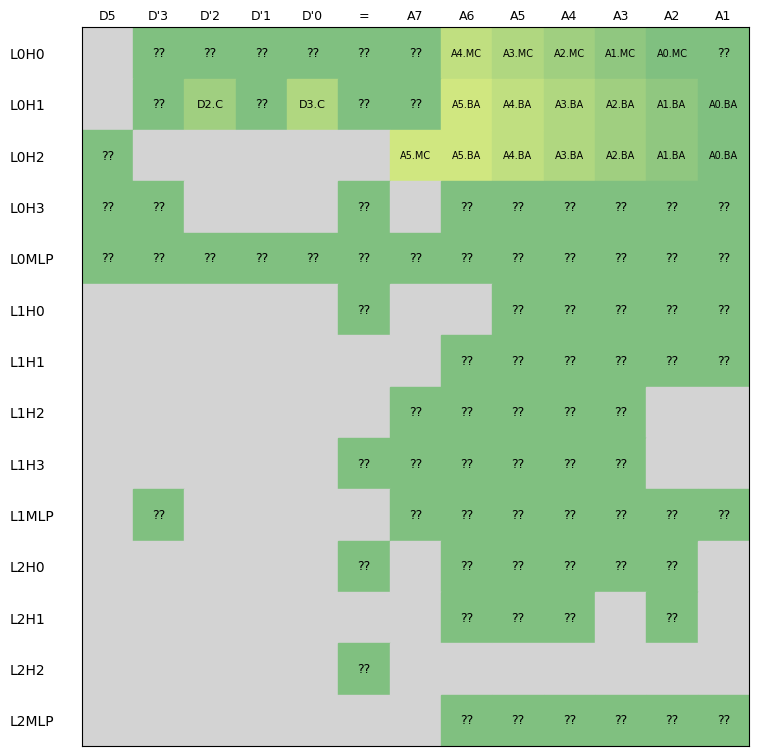

In [ ]:
def get_algorithm_purpose( node, major_version, minor_version, shades):

  cell_text = node.min_tag_suffix( major_version, minor_version )
  color_index = 0

  if len(cell_text) > 0:
    color_index = int(cell_text[1]) if len(cell_text) > 1 and cell_text[1].isdigit() else shades-1
  else:
    cell_text = "??"

  return cell_text, color_index


show_quanta_map( "Algorithm purpose per node", create_custom_colormap(), cfg.n_digits+2, ALGORITHM_MAJOR_TAG, "", get_algorithm_purpose, 9)

# Part21E: Save useful nodes and tags to JSON file

Show a list of the nodes that have proved useful in calculations.
For each useful node, show its useful facts, stored as tags.
Save the data to a Colab temporary JSON file.



In [ ]:
ccfg.print_node_tags()

P0L0H2 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:M1', 'Attn:P0=100']
P0L0H3 ['FailPerc:5', 'Impact:A7', 'Complexity.Sub:M013', 'Attn:P0=100']
P0L0H4 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:M13']
P9L0H0 ['FailPerc:7', 'Impact:A765', 'Complexity.Add:S01234', 'Complexity.Sub:M13', 'Attn:P8=53', 'Attn:P1=47']
P9L0H1 ['FailPerc:0', 'Impact:A654', 'Complexity.Add:S124', 'Attn:P8=53', 'Attn:P1=46']
P9L0H3 ['FailPerc:0', 'Impact:A5', 'Complexity.Sub:NG', 'Attn:P6=79', 'Attn:P9=7', 'Attn:P8=4', 'Attn:P7=3']
P9L0H4 ['FailPerc:14', 'Impact:A765', 'Complexity.Add:S12345', 'Complexity.Sub:M0123']
P9L1H4 ['FailPerc:0', 'Impact:A7', 'Complexity.Sub:NG']
P10L0H0 ['FailPerc:0', 'Impact:A54', 'Complexity.Add:S13', 'Attn:P10=51', 'Attn:P3=48']
P10L0H1 ['FailPerc:0', 'Impact:A76543', 'Complexity.Add:S234', 'Complexity.Sub:M12', 'Attn:P3=50', 'Attn:P10=50', 'Algorithm:D2.C']
P10L0H4 ['FailPerc:10', 'Impact:A76543', 'Complexity.Add:S12345', 'Complexity.Sub:M012']
P11L0H0 ['FailPerc:0', 'Impact:A3', 'C

In [ ]:
# Serialize and save the useful nodes list to a temporary CoLab file in JSON format
print( "Saving useful node list with quanta tags:", main_fname_json)

dict_list = [node.to_dict() for node in ccfg.useful_nodes]
with open(main_fname_json, 'w') as file:
    json.dump(dict_list, file, default=lambda o: o.__dict__)

Saving useful node list with quanta tags: ins1_mix_d6_l3_h4_train40K_seed372001_tags.json


# Part 21F: TBA

In [ ]:
print( "Claim that P10.L0.H1 performs D1.C2 = TriAdd(V1.C, TriCase(D0, D0’)) impacting A5, A4, A3 & A2 accuracy")
print()
nodes = [[10, 0, 1]]

store_question = [ 11111, 33333] # Sum is 044444. V0 has no MC.
alter_question = [ 44444, 55555] # Sum is 099999. V0 has no MC
run_intervention( nodes, store_question, alter_question, NO_IMPACT_TAG, 99999 )

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [ 44444, 55555] # Sum is 099999. V0 has no MC
run_intervention( nodes, store_question, alter_question, "A5432", 100099 )

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [  4444,  5555] # Sum is 009999. V0 has no MC
run_intervention( nodes, store_question, alter_question, "A432", 10099 )

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [   444,   555] # Sum is 000999. V0 has no MC
run_intervention( nodes, store_question, alter_question, "A32", 1099 )

store_question = [ 11117, 11117] # Sum is 022234. V0 has MC
alter_question = [    44,    55] # Sum is 000099. V0 has no MC
run_intervention( nodes, store_question, alter_question, "A2", 199 )

# Deprecated: Confirmed that P10.L0.H1 is: Based on D0 and D0'. Triggers on a V0 carry value. Provides "carry 1" used in A5, A4, A3 & A2 calculation.

Claim that P10.L0.H1 performs D1.C2 = TriAdd(V1.C, TriCase(D0, D0’)) impacting A5, A4, A3 & A2 accuracy

Intervening on P10L0H1
Failed (prediction/expected): (none) A5432 +0099999 +0100099
Intervening on P10L0H1
Failed (prediction/expected): (none) A432 +0009999 +0010099
Intervening on P10L0H1
Failed (prediction/expected): (none) A32 +0000999 +0001099
Intervening on P10L0H1
Failed (prediction/expected): (none) A2 +0000099 +0000199


(False, '+0000099', 'Intervening on P10L0H1')

In [ ]:
print( "Claim that P11.L0.H1 performs D3.C4 = TriAdd(TriCase(D3, D3’),TriAdd(V2.C,V1.C2)) impacting A5 accuracy")
print()
nodes = [[11, 0, 1]]

store_question = [44444, 44444] # Sum is 088888. V3 sums to 8 (has no MC).
alter_question = [11111, 11111] # Sum is 022222. V3 has no MC.
run_intervention( nodes, store_question, alter_question, NO_IMPACT_TAG, 22222 )

store_question = [16111, 13111] # Sum is 032111. V3 sums to 9 (has no MC).
alter_question = [44444, 55555] # Sum is 099999. V3 has no MC
run_intervention( nodes, store_question, alter_question, NO_IMPACT_TAG, 99999 )

store_question = [16111, 16111] # Sum is 032111. V3 has MC
alter_question = [44444, 55555] # Sum is 099999. V3 has no MC
run_intervention( nodes, store_question, alter_question, "A5", 199999 )

# Deprecated: Confirmed that P11.L0.H1 is: Based on D3 and D3'. Triggers on a V3 carry value. Provides "carry 1" used in A5 calculations.

Claim that P11.L0.H1 performs D3.C4 = TriAdd(TriCase(D3, D3’),TriAdd(V2.C,V1.C2)) impacting A5 accuracy

Intervening on P11L0H1
Failed (prediction/expected): (none) A5 +0099999 +0199999


(False, '+0099999', 'Intervening on P11L0H1')

In [ ]:
print( "Claim that P11.L0.H2 performs D4.C = TriCase(D4, D4’) impacting A5 accuracy")
print()
nodes = [[11, 0, 2]]

store_question = [44444, 55555] # Sum is 099999. V4 has no MC.
alter_question = [11111, 11111] # Sum is 022222. V4 has no MC.
run_intervention( nodes, store_question, alter_question, NO_IMPACT_TAG, 22222)

store_question = [71111, 71111] # Sum is 100422. V4 has MC
alter_question = [44444, 55555] # Sum is 099999. V4 has no MC
run_intervention( nodes, store_question, alter_question, "A5", 199999 )

# Deprecated: Confirmed that P9.L0.H2 is: Based on D4 and D4'. Triggers on a V4 carry value. Provides "carry 1" used in A5 calculation.

Claim that P11.L0.H2 performs D4.C = TriCase(D4, D4’) impacting A5 accuracy

Intervening on P11L0H2
Failed (prediction/expected): (none) A5 +0099999 +0199999


(False, '+0099999', 'Intervening on P11L0H2')

#Part 22: MLP Visualisation (incomplete, on-hold)

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_mlp_neuron_activation(pos: int)>

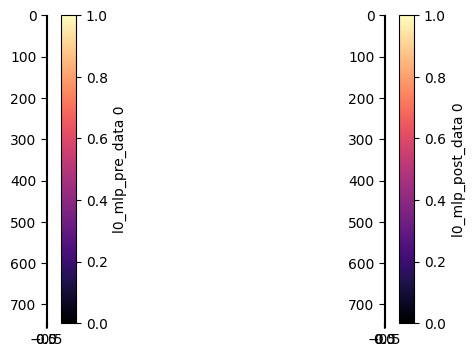

In [ ]:
import einops
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output


# number of questions in batch that generated sample_cache
num_questions = varied_questions.shape[0]


def get_mlp_data(data_set_name):

  data_set = sample_cache[data_set_name]
  # print( data_set_name + " shape", data_set.shape) # 239, 22, 2040 = num_questions, cfg.n_ctx, cfg.d_mlp

  raw_data = data_set[:,-3]
  # print( "raw_data shape", raw_data.shape) # 239, 2040 = num_questions, cfg.d_mlp

  answer = einops.rearrange(raw_data, "(x y) d_mlp -> x y d_mlp", x=num_questions).cpu().numpy()
  # print( "answer shape", answer.shape) # 239, 1, 2040 = num_questions, ??, cfg.d_mlp

  return answer


l0_mlp_hook_pre_sq = get_mlp_data('blocks.0.mlp.hook_pre')
l0_mlp_hook_post_sq = get_mlp_data('blocks.0.mlp.hook_post')
l1_mlp_hook_pre_sq = get_mlp_data('blocks.1.mlp.hook_pre') if cfg.n_layers > 1 else l0_mlp_hook_pre_sq
l1_mlp_hook_post_sq = get_mlp_data('blocks.1.mlp.hook_post') if cfg.n_layers > 1 else l0_mlp_hook_post_sq


def plot_mlp_neuron_activation(pos: int):
    clear_output()

    l0_mlp_pre_data = l0_mlp_hook_pre_sq[:,:,pos]
    l0_mlp_post_data = l0_mlp_hook_post_sq[:,:,pos]
    l1_mlp_pre_data = l1_mlp_hook_pre_sq[:,:,pos]
    l1_mlp_post_data = l1_mlp_hook_post_sq[:,:,pos]

    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    plot = axs[0].imshow(l1_mlp_pre_data, cmap='magma', vmin=0, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'l0_mlp_pre_data {}'.format(pos))
    #axs[0].set_ylim(-0.5, 99.5)
    #axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    #axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');

    plot = axs[1].imshow(l1_mlp_post_data, cmap='magma', vmin=0, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'l0_mlp_post_data {}'.format(pos))
    #axs[0].set_ylim(-0.5, 99.5)
    #axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    #axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');


interact(plot_mlp_neuron_activation, pos=widgets.IntText(value=0, description='Index:'))

# Part 25 : Is the model 100% accurate?

This is hard to prove. Can the model do 1M predictions without error?

Takes ~25 mins to run (successfully) for ins_mix_d6_l3_h4_train40K_seed372001

In [ ]:
def null_hook(value, hook):
  global verbose

  verbose = True

In [ ]:
def one_million_questions_core():
  global verbose
  global ds

  verbose = True

  cfg.analysis_seed = 345621 # Randomly chosen
  ds = data_generator() # Re-initialise the data generator

  the_successes = 0
  the_fails = 0

  num_batches = 1000000//cfg.batch_size
  for epoch in range(num_batches):
      tokens = next(ds)

      the_hook = [(l_attn_hook_z_name[0], null_hook)]
      the_fails = q_predict_questions(tokens, the_hook)

      if the_fails> 0:
        break

      the_successes = the_successes + cfg.batch_size

      if epoch % 100 == 0:
          print("Batch", epoch, "of", num_batches, "#Successes=", the_successes)

  print("successes", the_successes, "num_fails", the_fails)
  if the_fails > 0:
    "WARNING: Model is not fully accurate. It failed the 1M Q test"

In [ ]:
def one_million_questions():
  print_config()
  print()

  if model_might_be_fully_accurate:

    # Commented out as it takes > 9 minutes to run
    if cfg.perc_add() > 0 and cfg.perc_sub > 0:
      print("Subtraction:")
      cfg.perc_sub = 100
      one_million_questions_core()
      print()
      print("Addition:")
      cfg.perc_sub = 0
      one_million_questions_core()

    else:
      # Predict 1M (sub, add or mult) questions
      one_million_questions_core()

  else:
    print("WARNING: Model is not fully accurate. It failed some test questions")


# Takes ~25 minutes to run
# one_million_questions()